# Modules

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, date, time
import seaborn as sns
from scipy import stats
import scipy.stats as st
import glob
import warnings
import statsmodels.api as sm  

from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import pearsonr
from scipy.stats import f_oneway

from src.utils.data_utils import advanced_linear_regression
from src.utils.data_utils import assign_experience_level
from src.utils.data_utils import clean_location_column
from src.utils.data_utils import get_season
from src.utils.data_utils import merge_data_

In [2]:
# Suppress certain warnings
warnings.filterwarnings("ignore")

# Dataset

The dataset used in this analysis consists of beer reviews from two beer rating websites,**BeerAdvocate** and **RateBeer**, for a period ranging from 2001 to 2017. For each website, we have 5 files:
- users.csv: metadata about reviewers
- beers.csv : metadata about reviewed beers
- breweries.csv : metadata about breweries
- ratings.txt : all reviews given by users, including numerical ratings and sometimes textual reviews
- reviews.txt : only reviews given by users that include both numerical ratings and textual reviews

In our analysis, we will not use textual reviews. Thus, we will only use ratings.txt files and not reviews.txt files, as we will use all reviews, whether or not they include textual reviews.

### Load data into Dataframes

The .csv files are not too large and can efficiently be loaded into DataFrames.

In [3]:
BA_DATA_FOLDER = 'data/BeerAdvocate/'
RB_DATA_FOLDER = 'data/RateBeer/'

BA_USERS = BA_DATA_FOLDER+"users.csv"
BA_BEERS = BA_DATA_FOLDER+"beers.csv"
BA_BREWERIES = BA_DATA_FOLDER+"breweries.csv"

RB_USERS = RB_DATA_FOLDER+"users.csv"
RB_BEERS = RB_DATA_FOLDER+"beers.csv"
RB_BREWERIES = RB_DATA_FOLDER+"breweries.csv"

In [4]:
ba_users = pd.read_csv(BA_USERS)
ba_beers = pd.read_csv(BA_BEERS)
ba_breweries = pd.read_csv(BA_BREWERIES)

rb_users = pd.read_csv(RB_USERS)
rb_beers = pd.read_csv(RB_BEERS)
rb_breweries = pd.read_csv(RB_BREWERIES)

On the other hand, the ratings.txt files are extremely large, and trying to load them directly into DataFrames leads to kernel freezes. In order to circumvent this problem, we wrote a script (review_parser.py, located in src/scripts), which processes each rating file by dividing it into parts, parsing each part, and saving as JSON. In the notebook, we then load the different JSON files into DataFrames, that we concatenate. Dividing the large .txt files into smaller JSON chunks and then loading each chunk separately, avoids trying to load the entire file into memory at once, which can cause kernel freezes due to memory overload. In addition, JSON is a format that pandas can read efficiently.

In [5]:
# Load BeerAdvocate ratings stored in json files into a single DataFrame
ba_json_files = glob.glob(BA_DATA_FOLDER+'*.json')
ba_df_list = [pd.read_json(file) for file in ba_json_files]
ba_ratings = pd.concat(ba_df_list, ignore_index=True)
ba_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 09:59:28,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 10:59:12,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 10:59:12,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 10:59:12,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 09:59:28,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00


In [6]:
# Load RateBeer ratings stored in json files into a single DataFrame
rb_json_files = glob.glob(RB_DATA_FOLDER+'*.json')
rb_df_list = [pd.read_json(file) for file in rb_json_files]
rb_ratings = pd.concat(rb_df_list, ignore_index=True)
rb_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,33 Export (Gabon),410549.0,Sobraga,3198.0,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852.0,2.0,4.0,2.0,4.0,8.0,2.0
1,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761.0,2.0,3.0,2.0,4.0,8.0,1.9
2,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889.0,3.0,3.0,2.0,3.0,5.0,1.6
3,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510.0,4.0,3.0,1.0,2.0,5.0,1.5
4,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778.0,2.0,4.0,2.0,4.0,7.0,1.9


### First look at the data

We will now examine the different DataFrames in more detail.

**BeerAdvocate beer Dataframe**

In [7]:
ba_beers.sample(4)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
130153,182266,Simcoe IPA,33510,Other Half Brewing Co.,American IPA,108,14,4.18,91.0,NaN,7.20,4.153704,NaN,0,NaN
88643,69357,Z Man (Bourbon Barrel Aged),1337,Pizza Port Bressi Ranch,Foreign / Export Stout,16,6,3.94,85.0,NaN,NaN,4.015625,NaN,0,NaN
108091,214052,Dry Stout,40832,K2 (Kulshan Brewing Co.),Irish Dry Stout,1,0,3.56,NaN,NaN,4.15,3.560000,NaN,0,NaN
40595,234982,LP Pumpkin Ale,44871,Lippstädter Brauerei Brauhaus Thombansen,Pumpkin Ale,1,1,3.25,NaN,NaN,6.50,3.250000,-1.545377,1,3.25


Let us explain the different columns of the BeerAdvocate beer Dataframe, in which each row is a beer:
- beer_id, beer_name, brewery_id, brewery_name, style are explicit
- nbr_ratings: total number of reviews for that beer, whether or not they include textual reviews
- nbr_reviews: number of reviews for that beer that include textual reviews
- avg: average rating (out of 5) given to the beer based on user ratings
- ba_score: the BeerAdvocate score assigned to the beer, which corresponds to the beer's overall rating within its style category, calculated using a trimmed mean and a custom Bayesian formula that adjusts for the beer's style, balancing the score based on the number of ratings and the style's average
- bros_score: beer rating given by the site’s founders
- abv: 'Alcohol by volume', which indicates the percentage of alcohol content in the beer
- avg_computed: average rating (out of 5) recalculated using a weighted sum of the different aspect ratings
- zscore: z-score of the beer's average rating, which is a statistical measure that indicates how many standard deviations the average rating is from the mean of all ratings from the BeerAdvocate dataset
- nbr_matched_valid_ratings: number of valid ratings for beers that were successfully matched between two BeerAdvocate and RateBeer
- avg_matched_valid_ratings: average rating of those matched and valid ratings across the sites

The last two columns are related to the analysis performed by Robert West and Gael Lederrey in the following paper: https://dlab.epfl.ch/people/west/pub/Lederrey-West_WWW-18.pdf.

**RateBeer beer Dataframe**

In [8]:
rb_beers.sample(4)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
93601,1511,Tooheys Red Bitter,268,Tooheys (Lion Co.),Pale Lager,70,0.0,5.0,1.56,4.0,1.727143,NaN,0,NaN
381686,83389,Oakham Delirium,1100,Oakham,Premium Bitter/ESB,25,91.0,97.0,3.44,5.2,3.604000,NaN,0,NaN
131557,503313,Gotlands Daredevil Bulldog,5845,Gotlands Bryggeri (Spendrups),Session IPA,29,44.0,24.0,3.11,3.5,3.137931,NaN,0,NaN
1670,424591,The Brew (Shanghai) New World Pils,13745,The Brew (Shanghai),Pilsener,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN


Let us explain the different columns of the RateBeer beer Dataframe, in which each row is a beer:

The beer_id, beer_name, brewery_id, brewery_name, style, nbr_ratings, avg, abv, avg_computed, z-score, nbr_matched_valid_ratings and avg_matched_valid_ratings are the same as for the BeerAdvocate beer Dataframe.

Some columns are missing compared to the BeerAdvocate beer Dataframe: ba_score and bros_score (which makes sense as these are BeerAdvocate-specific scores), and nbr_reviews.

New columns are present compared to the BeerAdvocate beer Dataframe:
- overall_score: score (out of 100) which "reflects the rating given by RateBeer users and how this beer compares to all other beers on RateBeer", calculated by considering the ratings given by each user and the total number of ratings for the beer
- style_score: score given to the beer (out of 100) specifically within its style category

**Characteristics of the beer data**

Let us determine how many different beers are present in the dataset.

In [9]:
print('Number of different beers reviewed in Beer Advocate:', ba_beers.shape[0])
print('Number of different beers reviewed in Rate Beer:', rb_beers.shape[0])
print('Number of different beers reviewed in the combined datasets:', pd.concat([ba_beers['beer_id'], rb_beers['beer_id']]).nunique())

Number of different beers reviewed in Beer Advocate: 280823
Number of different beers reviewed in Rate Beer: 442081
Number of different beers reviewed in the combined datasets: 502784


Let us determine how many different beer styles are present in the dataset.

In [10]:
print('Number of different beer styles reviewed in Beer Advocate:', ba_beers['style'].nunique())
print('Number of different beer styles reviewed in Rate Beer:', rb_beers['style'].nunique())
print('Number of different beer styles reviewed in the combined datasets:', pd.concat([ba_beers['style'], rb_beers['style']]).nunique())

Number of different beer styles reviewed in Beer Advocate: 104
Number of different beer styles reviewed in Rate Beer: 94
Number of different beer styles reviewed in the combined datasets: 184


**BeerAdvocate user Dataframe**

In [11]:
ba_users.sample(4)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
68311,3,0,captain33.663847,Captain33,1.331377e+09,"United States, Michigan"
31809,5,0,pjo222.1193983,Pjo222,1.489403e+09,Canada
76517,19,0,denjhe.632138,Denjhe,1.319623e+09,"United States, New Jersey"
124376,8,0,lackofintellect.524493,lackofintellect,1.289473e+09,"United States, Georgia"


Let us explain the different columns of the BeerAdvocate user Dataframe, in which each row is a reviewer:
- nbr_ratings, nbr_reviews, user_id, user_name, and location are explicit
- joined: timestamp indicating when the user joined BeerAdvocate in Unix timestamp format (the number of seconds since January 1, 1970, 00:00:00 UTC)

**RateBeer user Dataframe**

In [12]:
rb_users.sample(4)

,nbr_ratings,user_id,user_name,joined,location
31508,1,335978,brazilhead,1.410948e+09,NaN
33320,12,100560,franciscus81,1.264331e+09,Netherlands
11237,68,84481,hopheaven,1.229166e+09,"United States, Missouri"
35536,1,352007,bobby_orr,1.420715e+09,"United States, Massachusetts"


Let us explain the different columns of the RateBeer user Dataframe, in which each row is a reviewer:

The columns are the same as in the BeerAdvocate user Dataframe (joined is obviously the timestamp indicating when the user joined RateBeer and not BeerAdvocate), except that nbr_reviews is missing.

**Number of users in the dataset**

In [13]:
print('Number of users from Beer Advocate:', ba_users.shape[0])
print('Number of users from Rate Beer:', rb_users.shape[0])
print('Total number of users:', (ba_users.shape[0] + rb_users.shape[0]))

Number of users from Beer Advocate: 153704
Number of users from Rate Beer: 70174
Total number of users: 223878


**Brewery Dataframes**

In [14]:
ba_breweries.sample(4)

,id,location,name,nbr_beers
8729,46842,"United States, California",Loma Brewing Company,10
4850,39061,Switzerland,La Brasserie du Manoir,1
13909,36077,"United States, Texas",Flight School Brewing,0
2913,23061,Italy,Pfefferlechner,0


In [15]:
rb_breweries.sample(4)

,id,location,name,nbr_beers
1235,30079,Canada,Think Brewing Company,2
22051,6282,England,Union Brewery &#40;UK&#41;,2
20446,27386,England,Hetton Law Brewery,3
22263,2811,England,DarkTribe,14


The columns are explicit and are the same for the 2 websites. Each row is a brewery.

**Rating Dataframes**

In [16]:
ba_ratings.sample(4)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
3548515,Saranac 4059' Porter,86601.0,Matt Brewing Company / Saranac Brewery,99.0,English Porter,5.2,2013-12-28 11:00:00,podes,podes.736156,NaN,NaN,NaN,NaN,NaN,3.50
3042875,Samuel Adams Winter Lager,101.0,Boston Beer Company (Samuel Adams),35.0,Bock,5.6,2012-01-12 11:00:00,ShucksBruh,shucksbruh.654385,NaN,NaN,NaN,NaN,NaN,4.00
5692289,Black Angel Cherry Sour,92695.0,Wicked Weed Brewing,30581.0,American Wild Ale,6.6,2014-05-16 09:59:28,oline73,oline73.371504,NaN,NaN,NaN,NaN,NaN,3.50
2216863,2 Hop (Delta & Comet),207369.0,Faction Brewing,33181.0,American Pale Ale (APA),NaN,2016-02-14 10:59:12,erjaq,erjaq.936809,4.0,4.25,4.0,4.0,4.0,4.06


In [17]:
rb_ratings.sample(4)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
4418606,Boulevard Single-Wide I.P.A.,95150.0,Boulevard Brewing Company &#40;Duvel-Moortgat&...,22.0,India Pale Ale (IPA),5.7,2016-07-12 09:59:28,artemb,122088.0,3.0,6.0,3.0,7.0,13.0,3.2
4262245,Upland Blackberry Lambic,77319.0,Upland Brewing Company,508.0,Lambic Style - Fruit,NaN,2008-11-18 10:59:12,PilsnerPeter,36307.0,4.0,8.0,4.0,8.0,15.0,3.9
3488161,Clown Shoes The Barista,392666.0,Clown Shoes Beer,12524.0,American Strong Ale,8.0,2016-07-31 09:59:28,BVery,85741.0,3.0,8.0,4.0,8.0,15.0,3.8
3938659,Great Divide Yeti Imperial Stout - Chocolate O...,103422.0,Great Divide Brewing Company,292.0,Imperial Stout,9.5,2015-04-18 09:59:28,fidelis83,65408.0,5.0,8.0,3.0,8.0,16.0,4.0


The columns are the same for the 2 Dataframes. Each row corresponds to an individual review. Most column names are explicit. 
- 'appearance','aroma', 'palate','taste' correspond to aspect ratings (out of 5)
- 'overall' is the mean of the 4 aspect ratings
- 'rating' is the final rating given by the user to the beer

**Number of reviews in the dataset**

In [18]:
print('Number of reviews from Beer Advocate:', ba_ratings.shape[0])
print('Number of reviews from Rate Beer:', rb_ratings.shape[0])
print('Total number of reviews:', (ba_ratings.shape[0] + rb_ratings.shape[0]))

Number of reviews from Beer Advocate: 8393034
Number of reviews from Rate Beer: 7122076
Total number of reviews: 15515110


# 0) Data cleaning

### **BASIC CLEANING**

## Filtering Dataframes

Let us start by removing columns in the different Dataframes that we will not use in our analysis.

The following rows will not be used in our analysis:
nbr_reviews, ba_score, bros_score, abv, avg_computed, zscore, nbr_matched_valid_ratings and avg_matched_valid_ratings, overall_score and style_score.

Let us remove them.

In [19]:
useless_columns_ba = ['nbr_reviews', 'ba_score', 'bros_score', 'abv', 'avg_computed', 'zscore', 'nbr_matched_valid_ratings', 'avg_matched_valid_ratings']
ba_beers = ba_beers.drop(columns=useless_columns_ba)
print(ba_beers.columns)

Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg'],
      dtype='object')


In [20]:
useless_columns_rb = [col for col in useless_columns_ba if col not in ['nbr_reviews','ba_score', 'bros_score']] + ['overall_score', 'style_score']
rb_beers = rb_beers.drop(columns=useless_columns_rb)
print(rb_beers.columns)

Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg'],
      dtype='object')


We will also not use the timestamps indicating the time when users joined the platforms, so let us remove this as well.

In [21]:
ba_users = ba_users.drop(columns='joined')
rb_users = rb_users.drop(columns='joined')
print(ba_users.columns)

Index(['nbr_ratings', 'nbr_reviews', 'user_id', 'user_name', 'location'], dtype='object')


## Verifying value types

Let us verify that the values in the different columns of the different Dataframes have the appropriate type.

In [22]:
print(ba_beers.dtypes,'\n','\n',rb_beers.dtypes)

beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object 
 
 beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object


In [23]:
print(ba_users.dtypes,'\n','\n',rb_users.dtypes)

nbr_ratings     int64
nbr_reviews     int64
user_id        object
user_name      object
location       object
dtype: object 
 
 nbr_ratings     int64
user_id         int64
user_name      object
location       object
dtype: object


In [24]:
print(ba_breweries.dtypes,'\n','\n',rb_breweries.dtypes)

id            int64
location     object
name         object
nbr_beers     int64
dtype: object 
 
 id            int64
location     object
name         object
nbr_beers     int64
dtype: object


In [25]:
print(ba_ratings.dtypes,'\n','\n',rb_ratings.dtypes)

beer_name               object
beer_id                float64
brewery_name            object
brewery_id             float64
style                   object
abv                    float64
date            datetime64[ns]
user_name               object
user_id                 object
appearance             float64
aroma                  float64
palate                 float64
taste                  float64
overall                float64
rating                 float64
dtype: object 
 
 beer_name               object
beer_id                float64
brewery_name            object
brewery_id             float64
style                   object
abv                    float64
date            datetime64[ns]
user_name               object
user_id                float64
appearance             float64
aroma                  float64
palate                 float64
taste                  float64
overall                float64
rating                 float64
dtype: object


The types of the values in the different columns of the different Dataframes seem appropriate.

## Dealing with missing values

*Beers with no reviews*

Let us verify that all the beers in the beer DataFrames have at least received 1 review.

In [26]:
# get the number of beers with 0 reviews
# Beer Advocate
ba_beers_without_reviews = ba_beers[ba_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Beer Advocate):',ba_beers_without_reviews)

# Rate Beer
rb_beers_without_reviews = rb_beers[rb_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Rate Beer):',rb_beers_without_reviews)

Number of beers with no reviews (Beer Advocate): 32841
Number of beers with no reviews (Rate Beer): 45391


We can see that in Both Dataframes, there are many beers with no reviews. These beers are useless for our analysis and we can remove them from the DataFrames.

In [27]:
# remove beers with zero reviews
# Beer Advocate
ba_beers = ba_beers[ba_beers['nbr_ratings'] != 0]
# Rate Beer
rb_beers = rb_beers[rb_beers['nbr_ratings'] != 0]

# verification:
ba_beers_without_reviews = ba_beers[ba_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Beer Advocate):',ba_beers_without_reviews)
rb_beers_without_reviews = rb_beers[rb_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Rate Beer):',rb_beers_without_reviews)

Number of beers with no reviews (Beer Advocate): 0
Number of beers with no reviews (Rate Beer): 0


*Reviews with no final rating*

Let us now determine if some reviews lack a final rating. If that is the case, we will remove them from the rating DataFrames as we will need final ratings in our analysis. The final rating, unlike the overall rating, cannot be calculated using aspect ratings, so we cannot retrieve missing final rating values. Some reviews may lack certain aspect ratings, but we will not remove them as if they do have a final rating, we will be able to use them in many parts of our analysis.

In [28]:
# get the number of reviews with Nan in the 'rating' column
# Beer Advocate
print('Number of reviews lacking a final rating (Beer Advocate):',ba_ratings['rating'].isna().sum())
# Rate Beer
print('Number of reviews lacking a final rating (Rate Beer):',rb_ratings['rating'].isna().sum())

Number of reviews lacking a final rating (Beer Advocate): 2
Number of reviews lacking a final rating (Rate Beer): 2


There are only 2 reviews lacking a final rating for each website, but let us remove them anyway.

In [29]:
# remove reviews with no final rating
ba_ratings = ba_ratings.dropna(subset=['rating'])
rb_ratings = rb_ratings.dropna(subset=['rating'])

# verification 
print('Number of reviews lacking a final rating (Beer Advocate):',ba_ratings['rating'].isna().sum())
print('Number of reviews lacking a final rating (Rate Beer):',rb_ratings['rating'].isna().sum())

Number of reviews lacking a final rating (Beer Advocate): 0
Number of reviews lacking a final rating (Rate Beer): 0


## Cleaning location information

Let us have a closer look at the values present in the 'location' column of user and brewery DataFrames.

In [30]:
ba_users['location'].value_counts()

location
United States, California       11638
United States, Pennsylvania      8689
United States, New York          7432
United States, Illinois          6866
United States, Massachusetts     6658
                                ...  
Angola                              1
Kazakhstan                          1
Tokelau                             1
Sri Lanka                           1
Sint Maarten                        1
Name: count, Length: 194, dtype: int64

In [31]:
rb_users['location'].value_counts()

location
Canada                         3255
United States, California      2804
England                        2734
Poland                         1701
United States, Pennsylvania    1632
                               ... 
Liechtenstein                     1
Lesotho                           1
East Timor                        1
Falkland Islands                  1
Tibet                             1
Name: count, Length: 222, dtype: int64

In [32]:
ba_breweries['location'].value_counts()

location
Germany                                                                                                                                                                          1431
England                                                                                                                                                                           997
United States, California                                                                                                                                                         929
Canada                                                                                                                                                                            775
United States, Washington                                                                                                                                                         411
                                                                                 

In [33]:
rb_breweries['location'].value_counts()

location
England                      2124
Germany                      1999
Italy                        1051
Canada                        884
United States, California     867
                             ... 
Senegal                         1
Mozambique                      1
French Polynesia                1
Papua New Guinea                1
Gabon                           1
Name: count, Length: 267, dtype: int64

In [34]:
# see all the possibilities for locations containing 'Wales', 'Scotland', 'England' or 'Ireland'
ba_breweries[ba_breweries['location'].str.contains('Wales|Scotland|England|Ireland', case=False, na=False)]['location'].value_counts()

location
England                     997
Scotland                    104
Ireland                      84
Wales                        58
United Kingdom, England      32
Northern Ireland             25
United Kingdom, Scotland      3
United Kingdom, Wales         2
Name: count, dtype: int64

In [35]:
# see all the possibilities for locations starting with 'Canada'
ba_breweries[ba_breweries['location'].str.startswith('Canada', na=False)]['location'].value_counts()

location
Canada                               775
Canada, Quebec                        28
Canada, Ontario                       25
Canada, British Columbia              12
Canada, Nova Scotia                    6
Canada, Alberta                        6
Canada, Manitoba                       3
Canada, Saskatchewan                   2
Canada, New Brunswick                  2
Canada, Newfoundland and Labrador      1
Name: count, dtype: int64

We can make 4 important observations: 
- US locations all contain state information
- some locations contain embedded HTML links
- Canada locations contain province information
- UK countries are represented in 2 different ways: either 'United Kingdom, *country*' or '*country*'

We will remove both these HTML links and the state and province information, as we will not use it in our analysis. We will also make sure that UK countries are represented in only 1 way. We will do so by applying a function named 'clean_location_column' which cleans the location information and that we have written in src/utils/data_utils.py().

In [36]:
# Clean location information in user and brewery dataframes
# Beer Advocate
ba_users = clean_location_column (ba_users)
ba_breweries = clean_location_column (ba_breweries)

# Rate Beer
rb_users = clean_location_column (rb_users)
rb_breweries = clean_location_column (rb_breweries)

Let us now have a look at the cleaned location columns.

In [37]:
ba_users['location'].value_counts()

location
United States                               113223
nan                                          31279
Canada                                        3324
England                                        791
Australia                                      520
                                             ...  
South Georgia and South Sandwich Islands         1
Angola                                           1
Kazakhstan                                       1
Egypt                                            1
Sint Maarten                                     1
Name: count, Length: 146, dtype: int64

In [38]:
rb_users['location'].value_counts()

location
United States       26855
nan                 19582
Canada               3255
England              2734
Poland               1701
                    ...  
Honduras                1
Falkland Islands        1
Kyrgyzstan              1
Papua New Guinea        1
Tibet                   1
Name: count, Length: 174, dtype: int64

In [39]:
ba_breweries['location'].value_counts()

location
United States               7399
Germany                     1431
England                     1029
Canada                       860
France                       402
                            ... 
Dominica                       1
French Guiana                  1
Senegal                        1
Gibraltar                      1
Virgin Islands (British)       1
Name: count, Length: 200, dtype: int64

In [40]:
rb_breweries['location'].value_counts()

location
United States            6921
England                  2124
Germany                  1999
Italy                    1051
Canada                    884
                         ... 
Sao Tome and Principe       1
Iraq                        1
Micronesia                  1
French Guiana               1
Gabon                       1
Name: count, Length: 217, dtype: int64

In [41]:
# see all the possibilities for locations containing 'Wales', 'Scotland', 'England' or 'Ireland'
ba_breweries[ba_breweries['location'].str.contains('Wales|Scotland|England|Ireland', case=False, na=False)]['location'].value_counts()

location
England             1029
Scotland             107
Ireland               84
Wales                 60
Northern Ireland      25
Name: count, dtype: int64

In [42]:
# see all the possibilities for locations starting with 'Canada'
ba_breweries[ba_breweries['location'].str.startswith('Canada', na=False)]['location'].value_counts()

location
Canada    860
Name: count, dtype: int64

Now that the location information has been cleaned, we can look a the distribution of the location of both users and breweries in the dataset.

Let us start by observing the distribution of user locations.

In [43]:
print('Number of distinct user locations:',pd.concat([ba_users['location'],rb_users['location']]).nunique())

Number of distinct user locations: 202


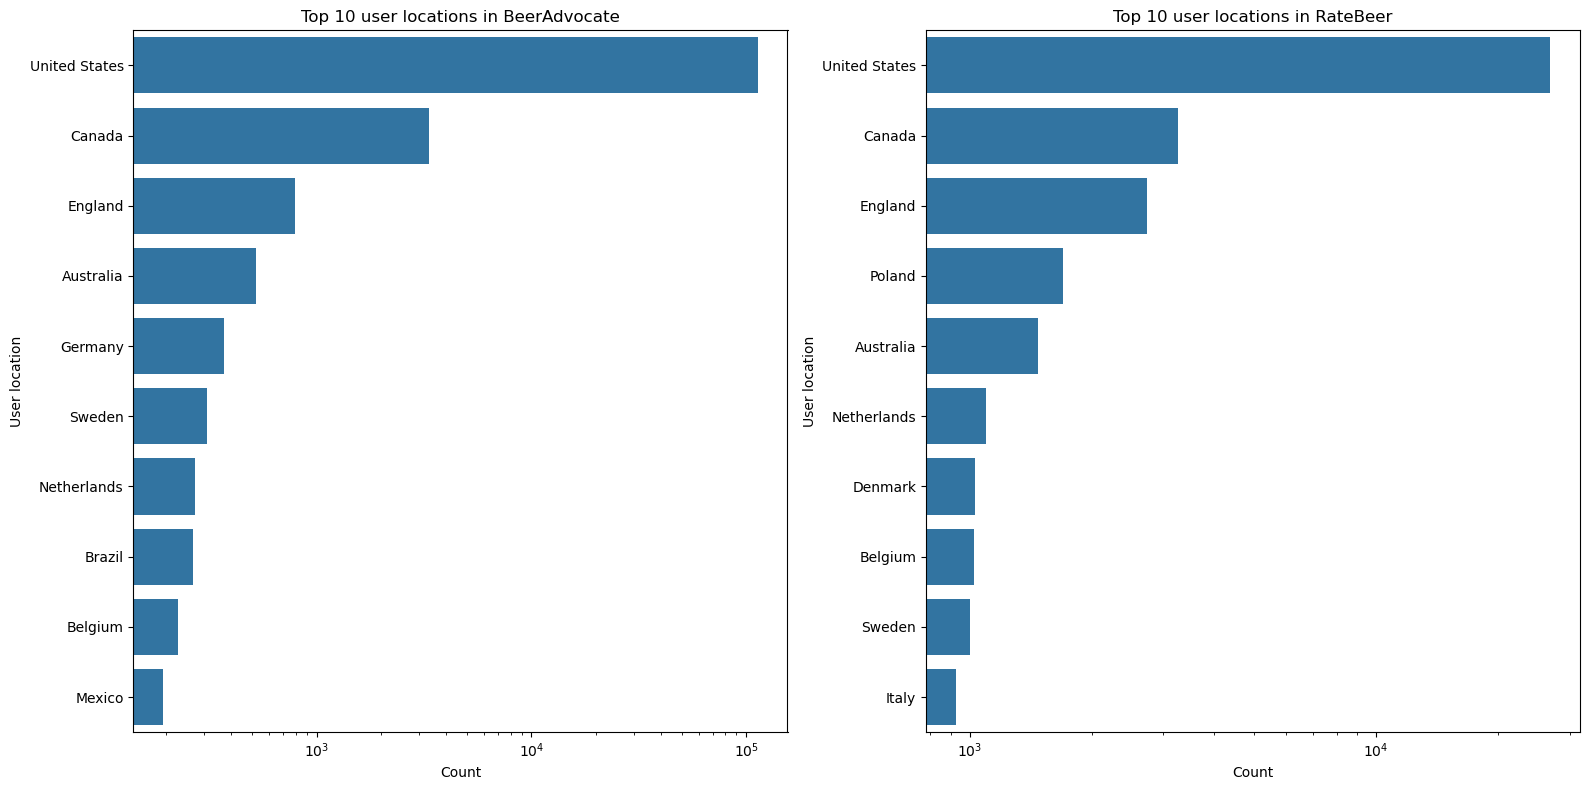

In [44]:
# Distribution of user locations
# 10 most frequent user locations for each dataset (to make plots easier to read)
ba_top_10_user_locations = ba_users[ba_users['location'] != 'nan']['location'].value_counts().head(10)
rb_top_10_user_locations = rb_users[rb_users['location'] != 'nan']['location'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(x=ba_top_10_user_locations.values, y=ba_top_10_user_locations.index, ax=axes[0])
axes[0].set_title("Top 10 user locations in BeerAdvocate")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("User location")
axes[0].set_xscale("log")

sns.barplot(x=rb_top_10_user_locations.values, y=rb_top_10_user_locations.index, ax=axes[1])
axes[1].set_title("Top 10 user locations in RateBeer")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("User location")
axes[1].set_xscale("log")

plt.tight_layout()
plt.show()
plt.close()

We can see that for the 2 websites, the vast majority of users come from the US. The next most common user locations are Canada and England.

Let us now observe the distribution of brewery locations.

In [45]:
print('Number of distinct brewery locations:',pd.concat([ba_breweries['location'],rb_breweries['location']]).nunique())

Number of distinct brewery locations: 218


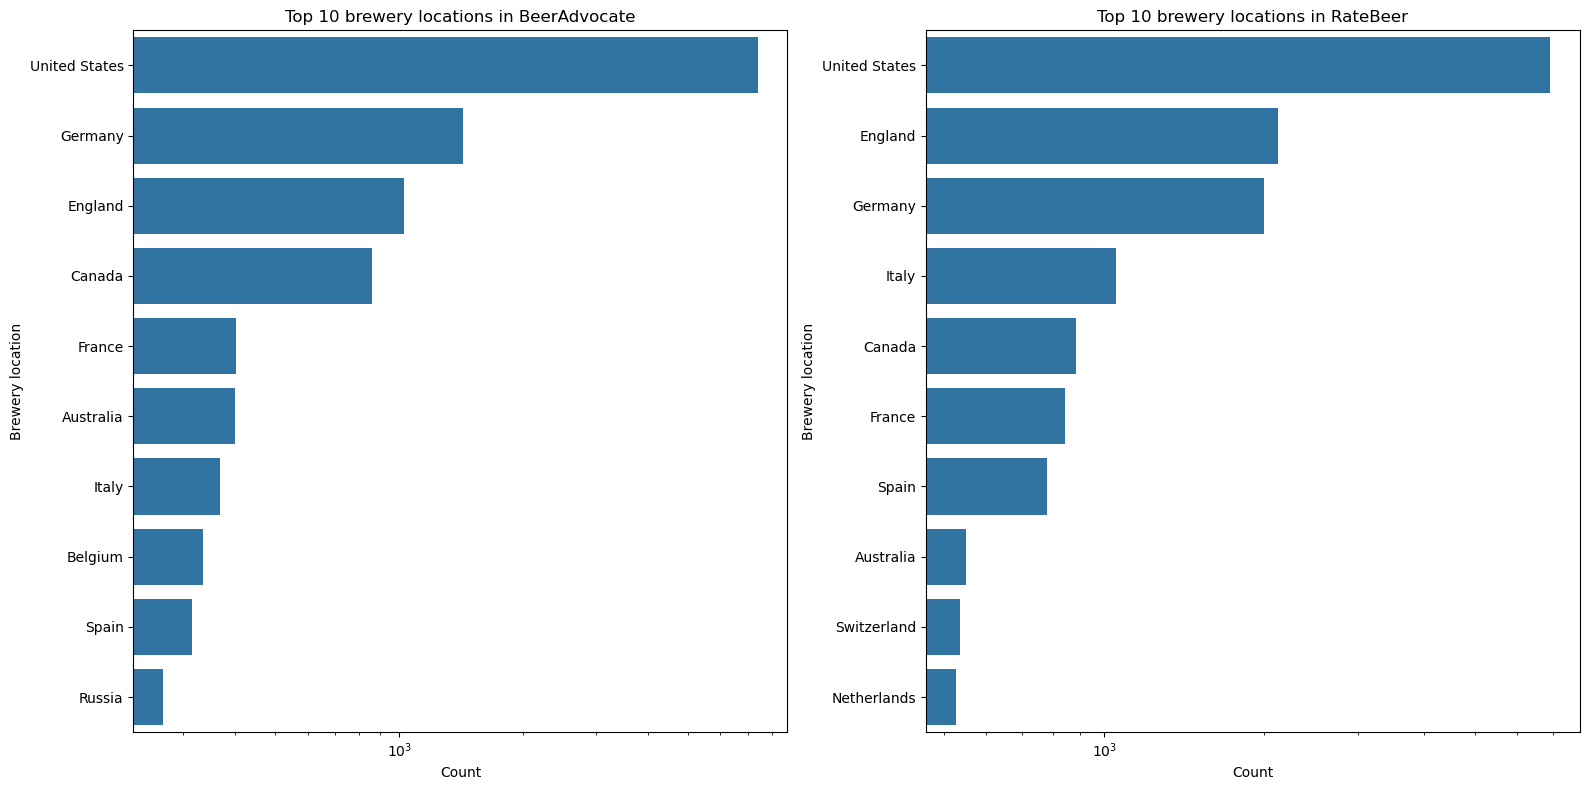

In [46]:
# Distribution of brewery locations
# 10 most frequent brewery locations for each dataset (to make plots easier to read)
ba_top_10_brewery_locations = ba_breweries[ba_breweries['location'] != 'nan']['location'].value_counts().head(10)
rb_top_10_brewery_locations = rb_breweries[rb_breweries['location'] != 'nan']['location'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(x=ba_top_10_brewery_locations.values, y=ba_top_10_brewery_locations.index, ax=axes[0])
axes[0].set_title("Top 10 brewery locations in BeerAdvocate")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Brewery location")
axes[0].set_xscale("log")

sns.barplot(x=rb_top_10_brewery_locations.values, y=rb_top_10_brewery_locations.index, ax=axes[1])
axes[1].set_title("Top 10 brewery locations in RateBeer")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Brewery location")
axes[1].set_xscale("log")

plt.tight_layout()
plt.show()
plt.close()

Similarly, we can observe that the vast majority of breweries included in the 2 datasets are located in the US. The next most common brewery locations are Germany and England.

### **'LOCATION-SPECIFIC' CLEANING**

Several parts of our analysis will involve comparing data from different countries and will require working with the location information in the user DataFrames. In these parts, we will only consider countries with a 'sufficiently large' number of reviewers, as only a few reviewers may not be representative of an entire country. We will thus filter out countries that we consider to have not enough reviewers. We decide arbitrarily to filter out countries with less than 50 different reviewers.

In this part of the data cleaning, we will work on a copy of the original DataFrames, and we will use these copies only for the parts of the analysis where we compare certain countries. Indeed, this filtering is not relevant for the parts that do not involve comparing certain countries.

In [47]:
# create copies of the user and rating DataFrames, which will undergo filtering related to the location information
ba_users_loc_filtered = ba_users.copy()
rb_users_loc_filtered = rb_users.copy()
ba_ratings_loc_filtered = ba_ratings.copy()
rb_ratings_loc_filtered = rb_ratings.copy()

## Removing users with missing location information

First, let us determine if some users are missing the location information.

In [48]:
# get the number of users with 'nan' in the 'location' column
# Beer Advocate
print('Number of users lacking the location information (Beer Advocate):',ba_users_loc_filtered[ba_users_loc_filtered['location'] == 'nan'].shape[0])
# Rate Beer
print('Number of users lacking the location information (Rate Beer):',rb_users_loc_filtered[rb_users_loc_filtered['location'] == 'nan'].shape[0])

Number of users lacking the location information (Beer Advocate): 31279
Number of users lacking the location information (Rate Beer): 19582


We can see that there are indeed some users missing the location information. Let us remove these users.

In [49]:
# remove users with 'nan' in the 'location' column
ba_users_loc_filtered = ba_users_loc_filtered[ba_users_loc_filtered['location'] != 'nan']
rb_users_loc_filtered = rb_users_loc_filtered[rb_users_loc_filtered['location'] != 'nan']

# verification
print('Number of users lacking the location information (Beer Advocate):',ba_users_loc_filtered[ba_users_loc_filtered['location'] == 'nan'].shape[0])
print('Number of users lacking the location information (Rate Beer):',rb_users_loc_filtered[rb_users_loc_filtered['location'] == 'nan'].shape[0])

Number of users lacking the location information (Beer Advocate): 0
Number of users lacking the location information (Rate Beer): 0


## Filtering out users and reviews written by users from countries with too few users

Let us first identify the countries with a number of users that is smaller than the threshold we set earlier, that is, 10 users.

In [50]:
USER_NB_THRESHOLD = 50

# concatenate the 'location' columns from the 2 user dataframes
combined_locations = pd.concat([ba_users_loc_filtered['location'], rb_users_loc_filtered['location']])

# get the counts of each unique value in 'location'
location_counts = combined_locations.value_counts()

# keep only locations with less than 50 counts
locations_with_few_counts = location_counts[location_counts < USER_NB_THRESHOLD]

# Get the list of location values with less than 50 counts
countries_with_few_users = locations_with_few_counts.index.tolist()

print("Countries with less than 50 users across both DataFrames:")
print(countries_with_few_users)

Countries with less than 50 users across both DataFrames:
['Aotearoa', 'Panama', 'Colombia', 'Bosnia and Herzegovina', 'Costa Rica', 'Cyprus', 'Luxembourg', 'Belarus', 'Dominican Republic', 'El Salvador', 'Peru', 'Moldova', 'Guatemala', 'Ecuador', 'Macedonia', 'Venezuela', 'Paraguay', 'Uruguay', 'Lebanon', 'Malaysia', 'Vietnam', 'Indonesia', 'Virgin Islands (U.S.)', 'Bahamas', 'Faroe Islands', 'Afghanistan', 'Malta', 'Andorra', 'Cambodia', 'Guam', 'Kenya', 'United Arab Emirates', 'Isle of Man', 'Antarctica', 'Cayman Islands', 'Bermuda', 'Bolivia', 'Honduras', 'Montenegro', 'Egypt', 'Tanzania', 'Uganda', 'Botswana', 'Zimbabwe', 'Albania', 'Tajikistan', 'Azerbaijan', 'Trinidad and Tobago', 'American Samoa', 'Tunisia', 'Jersey', 'Vanuatu', 'Pakistan', 'Jordan', 'Mauritius', 'Belize', 'Nicaragua', 'Barbados', 'Mozambique', 'Aruba', 'Uzbekistan', 'Nigeria', 'Palestine', 'Namibia', 'Abkhazia', 'Papua New Guinea', 'Armenia', 'Morocco', 'Nepal', 'Burkina Faso', 'Marshall Islands', 'Ascension I

Let us determine if filtering out these 113 countries would leave us with enough data, ie with enough countries, to perform our analysis comparing different countries.

In [51]:
print('Remaining countries after filtering:',(len(location_counts)-len(locations_with_few_counts)))

Remaining countries after filtering: 55


Filtering out those countries would leave us with 55 countries, which is enough to perform our analysis.

Ultimately, we would like to remove reviews from users coming from countries with too few reviewers. 
To do so, we will start by adding the user location information to review DataFrames. This will facilitate the filtering and analysis.

In [52]:
# merge rating dataframes with user dataframes on 'user_id' to add the'location' column to rating dataframes as 'user_location'

# Beer Advocate
ba_ratings_loc_filtered = ba_ratings_loc_filtered.merge(ba_users_loc_filtered[['user_id', 'location']], on='user_id', how='left')
ba_ratings_loc_filtered = ba_ratings_loc_filtered.rename(columns={'location': 'user_location'})

# Rate Beer
rb_ratings_loc_filtered = rb_ratings_loc_filtered.merge(rb_users_loc_filtered[['user_id', 'location']], on='user_id', how='left')
rb_ratings_loc_filtered = rb_ratings_loc_filtered.rename(columns={'location': 'user_location'})

ba_ratings_loc_filtered.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 09:59:28,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,United States
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 10:59:12,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,United States
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 10:59:12,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,Northern Ireland
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 10:59:12,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Northern Ireland
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 09:59:28,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,Northern Ireland


We now must remove the reviews from users whose location is NaN. Such users correspond to the users lacking a ocation information that have been previously removed from the user dataframes, but which are still present in the review dataframes.

In [53]:
# remove reviews from users for which the location is NaN
ba_ratings_loc_filtered = ba_ratings_loc_filtered.dropna(subset=['user_location'])
rb_ratings_loc_filtered = rb_ratings_loc_filtered.dropna(subset=['user_location'])

We can now remove reviews from users coming from countries with too few reviewers.

In [54]:
# remove reviews where 'user_location' is in the 'countries_with_few_users' list
ba_ratings_loc_filtered = ba_ratings_loc_filtered[~ba_ratings_loc_filtered['user_location'].isin(countries_with_few_users)]
rb_ratings_loc_filtered = rb_ratings_loc_filtered[~rb_ratings_loc_filtered['user_location'].isin(countries_with_few_users)]

We will now remove users coming from countries with too few reviewers from the user dataframes.

In [55]:
# remove users for which 'location' is in the 'countries_with_few_users' list
ba_users_loc_filtered = ba_users_loc_filtered[~ba_users_loc_filtered['location'].isin(countries_with_few_users)]
rb_users_loc_filtered = rb_users_loc_filtered[~rb_users_loc_filtered['location'].isin(countries_with_few_users)]

In [56]:
ba_users_loc_filtered.head()

,nbr_ratings,nbr_reviews,user_id,user_name,location
0,7820,465,nmann08.184925,nmann08,United States
1,2521,2504,stjamesgate.163714,StJamesGate,United States
2,1797,1143,mdagnew.19527,mdagnew,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,Northern Ireland


In [57]:
rb_users_loc_filtered.head()

,nbr_ratings,user_id,user_name,location
0,1890,175852,Manslow,Poland
1,89,442761,MAGICuenca91,Spain
2,169,288889,Sibarh,Poland
3,3371,250510,fombe89,Spain
4,13043,122778,kevnic2008,Germany


## Adding brewery location information to filtered review DataFrames

Finally, to facilitate our analysis, we will add the brewery location information for each beer reviewed in the review dataframes. 

In [58]:
ba_breweries_loc_filtered = ba_breweries.copy()
rb_breweries_loc_filtered = rb_breweries.copy()

In [59]:
# rename 'id' column to 'brewerie_id' column in brewery dataframes to facilitate merging with rating dataframes
ba_breweries_loc_filtered = ba_breweries_loc_filtered.rename(columns={'id': 'brewery_id'})
rb_breweries_loc_filtered = rb_breweries_loc_filtered.rename(columns={'id': 'brewery_id'})

# merge rating dataframes with brewery dataframes on 'brewery_id' to add the'location' column to rating dataframes as 'brewerie_location'

# Beer Advocate
ba_ratings_loc_filtered = ba_ratings_loc_filtered.merge(ba_breweries_loc_filtered[['brewery_id', 'location']], on='brewery_id', how='left')
ba_ratings_loc_filtered = ba_ratings_loc_filtered.rename(columns={'location': 'brewery_location'})

# Rate Beer
rb_ratings_loc_filtered = rb_ratings_loc_filtered.merge(rb_breweries_loc_filtered[['brewery_id', 'location']], on='brewery_id', how='left')
rb_ratings_loc_filtered = rb_ratings_loc_filtered.rename(columns={'location': 'brewery_location'})

ba_ratings_loc_filtered.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 09:59:28,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,United States,Gabon
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 10:59:12,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,United States,Northern Ireland
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 10:59:12,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,Northern Ireland,Northern Ireland
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 10:59:12,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Northern Ireland,Northern Ireland
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 09:59:28,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,Northern Ireland,Northern Ireland


# 1) Link between culture and taste

## a) Beer style preferences

In [60]:
# use clustering techniques to determine beer style is most popular in each country / geographic area
# use time information to determine if regional beer style preferences are stable (which would suggest that they are strongly affected by culture)or if they vary over time

# Note: I am still researching and looking the lecture slides because I am not sure how to show the whole data or which part of the data is feasible for the clustering. 
# I added some steps should be done under the Pale Lager analysis, but I think these are not necessarily needed in this P2 but I will continue to work on today evenning.

Here we concanated the two data frames together and added a source column so that we are not losing track of the origin of each rating.This data frame will be the main data frame for linear regression analysis and the clustering as it will give us the total ratings

In [61]:
total_ratings_loc_filtered = pd.concat([ba_ratings_loc_filtered, rb_ratings_loc_filtered], keys=['ba', 'rb']).reset_index(level=0).rename(columns={'level_0': 'source'})
total_ratings_loc_filtered = total_ratings_loc_filtered.reset_index(drop=True)
total_ratings_loc_filtered.head()

,source,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location
0,ba,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 09:59:28,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,United States,Gabon
1,ba,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 10:59:12,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,United States,Northern Ireland
2,ba,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 10:59:12,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,Northern Ireland,Northern Ireland
3,ba,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 10:59:12,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Northern Ireland,Northern Ireland
4,ba,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 09:59:28,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,Northern Ireland,Northern Ireland


Let's start with initial statistics about the which beers and beer styles are most commonly rated in overall data. Before analyzing the beer style preferences in each country or region, we should ensure that we have enough information in the data and whether it is consistent (for example, low variance and low bias) or not for clustering.

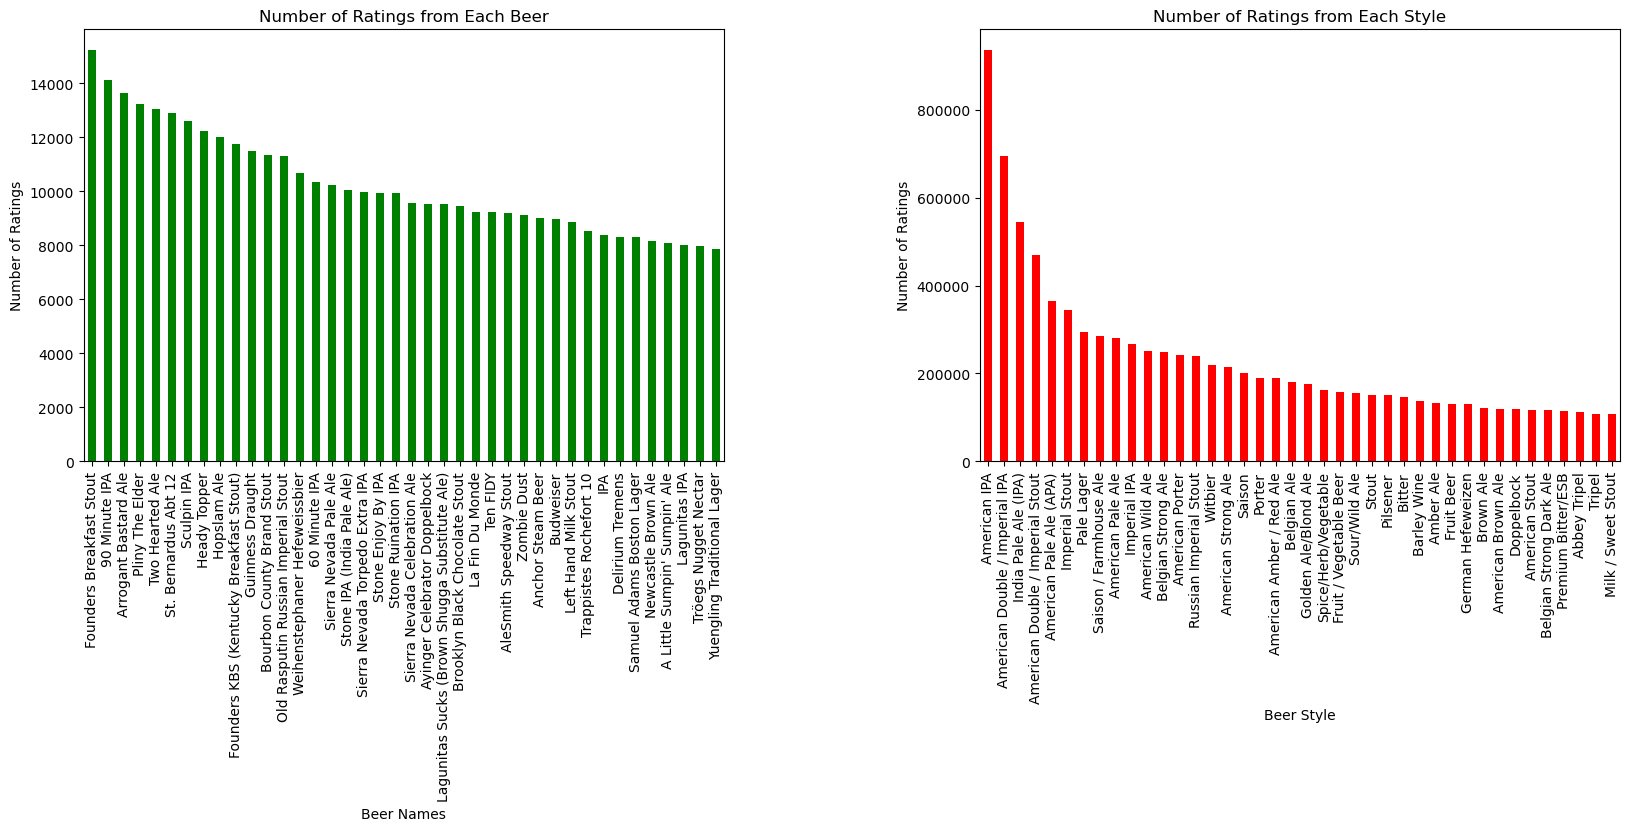

In [62]:
beer_name_values = total_ratings_loc_filtered['beer_name'].value_counts()
beer_style_values = total_ratings_loc_filtered['style'].value_counts()

plt.subplot(1,2,1)
beer_name_values[0:40].plot(kind='bar',color='g')
plt.title("Number of Ratings from Each Beer")
plt.xlabel("Beer Names")
plt.ylabel("Number of Ratings")

plt.subplot(1,2,2)
beer_style_values[0:40].plot(kind='bar',color='r')
plt.title("Number of Ratings from Each Style")
plt.xlabel("Beer Style")
plt.ylabel("Number of Ratings")

plt.subplots_adjust(left=1.5,bottom=0.1, right=3.9, top=1, wspace=0.4, hspace=2)

plt.show()

The histograms show that the distribution of ratings of popular beer brands and styles across the world based on BeerAdvocate and RateBeer data. In the left chart, the most-rated beer brand, "St. Bernardus Abt 12," received over 8,000 ratings, followed closely by "Guinness Draught" and other popular brands that have between 5,000 and 8,000 ratings. This partially indicates that there is almost an uniform distribution among the well-known brands. 

On the other hand, the right chart reveals that specific beer styles dominate in popularity. "American IPA" leads with over 550,000 ratings, followed by "India Pale Ale (IPA)" at around 500,000 ratings. Other styles like "Imperial Stout" and "Pale Ale" also feature prominently, with over 200,000 ratings each.

Let's further analyze the popular beer styles, for example consider the most famous one which is **'American IPA'**. Where are its ratings coming from? Is it really the most popular beer in the world or it is the leading one because of the number of users from specific regions dominate the ratings (in other words, basically it is the favorite preference of associated region)

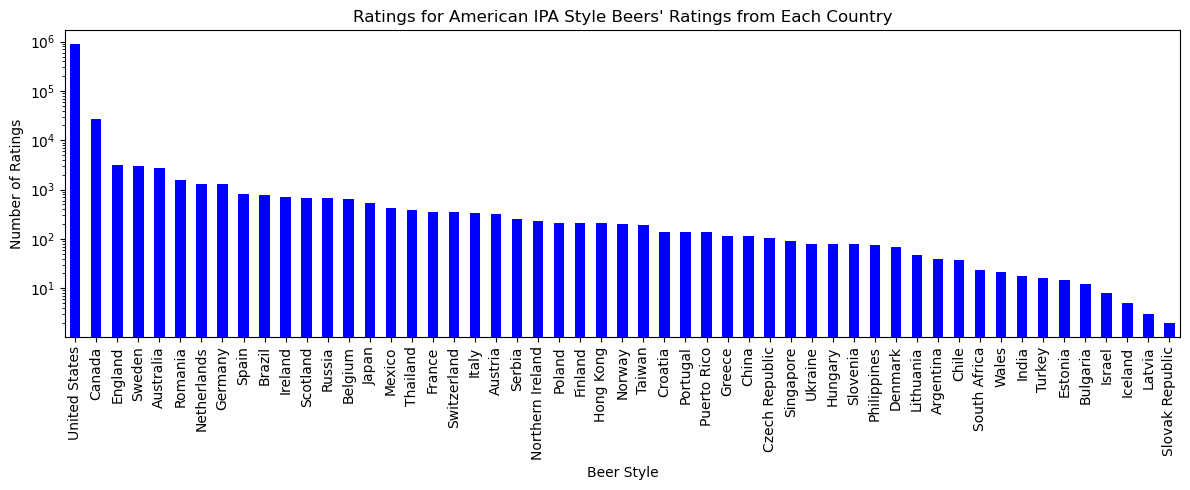

In [63]:
american_IPA_country_values = total_ratings_loc_filtered[total_ratings_loc_filtered['style'] == 'American IPA']
counts_american_IPA_values = american_IPA_country_values['user_location'].value_counts()

plt.figure(figsize=(12, 5))
counts_american_IPA_values[0:60].plot(kind='bar',color='b',logy = True)
plt.title("Ratings for American IPA Style Beers' Ratings from Each Country")
plt.xlabel("Beer Style")
plt.ylabel("Number of Ratings")
plt.tight_layout()

plt.show()

From the log scaled plot, we observe that the United States has a dominant lead in the number of ratings, reaching around 10^5 ratings, which is significantly higher than any other country. This dominance suggests that American IPA is extremely popular in its country of origin, aligning with the general preference for this style in the U.S. Following the U.S., Canada, Denmark, England, and Sweden also show notable levels of engagement, although their rating counts are much lower, in the range of 10^3 to 10^4. These countries represent regions with a strong craft beer culture, indicating that American IPA has gained substantial popularity internationally as well. The presence of other countries with moderate ratings, such as Germany, Netherlands, and Japan, suggests a widespread appreciation for this style, though at a smaller scale.

**To sum up, the chart demonstrates significant variation in preferences for the American IPA style across countries, with the United States showing an overwhelming number of ratings compared to other regions. This suggests that beer preferences are not uniform globally; instead, they exhibit clear regional patterns**

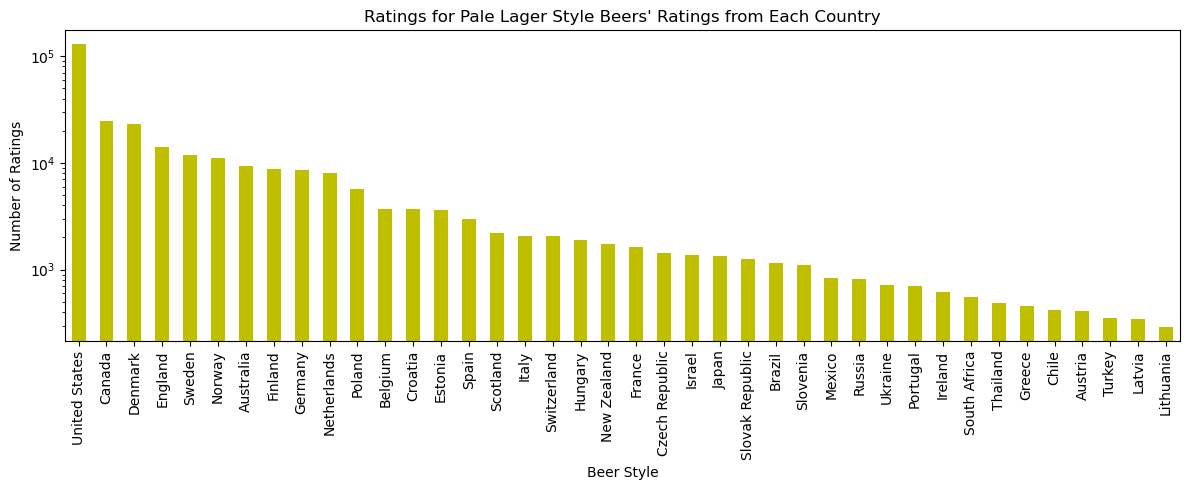

In [64]:
pale_lager_country_values = total_ratings_loc_filtered[total_ratings_loc_filtered['style'] == 'Pale Lager']
counts_pale_lager_values = pale_lager_country_values['user_location'].value_counts()

plt.figure(figsize=(12, 5))
counts_pale_lager_values[0:40].plot(kind='bar',color='y',logy = True)
plt.title("Ratings for Pale Lager Style Beers' Ratings from Each Country")
plt.xlabel("Beer Style")
plt.ylabel("Number of Ratings")
plt.tight_layout()

plt.show()

Let's also look at **Pale Lager** data which demonstrates that the difference between the U.S. and other countries is notably smaller for this beer style. European countries such as Denmark, England, Germany, and Sweden have substantial ratings even though the United States still leads with the highest number of ratings(because there are a significant number of users in particularly from U.S). This is in contrast to the American IPA style, which had a much stronger concentration of ratings in the United States, underscoring its origins and specific popularity in American craft beer culture. This distribution suggests that Pale Lager, in European countries, which have long-established beer cultures, particularly favor this style. This trend highlights the importance of considering regional preferences in beer style analysis, as Pale Lager’s popularity spans multiple regions, reflecting its acceptance as a global standard. It also underscores the need for clustering techniques to identify and analyze patterns based on these regional preferences.

**To implement the clustering to decide which beer style is most popular in each country / geographic area first we need to consider these steps:**

- Determine the axes initially, in our case these are the 1) countries, 2) beer styles and 3) number of ratings. Therefore, this suggests 3D dimensional visualization.
- For the countries, region of interests should be decided, we should determine each region that includes the choosing the countries (for example, we can divide Europe in different subsets such as West/East etc.) We are planning to use K-means clustering because we do not have the labels, we want to discover & reveal patterns like regional preferences or popular beer styles in specific countries.
- Since the U.S users are dominating the both BeerAdvocate and RateBeer data bases, we should find a solution to deal with this.
- Morever, simply number of ratings from each country are not enough to decide which beer style is most preferrable in the particular regions. Overall ratings, time effects should also be considered. Because of the possible dimension increase in the data, we will need to apply PCA to reduce the dimensionality of the dataset.

Let's visualize the initial data we have. First, we need to convert to data into useful frame:

In [74]:
merged_df = merge_data_(total_ratings_loc_filtered)

merged_df.head()

user_location,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Chile,China,Croatia,...,South Korea,Spain,Sweden,Switzerland,Taiwan,Thailand,Turkey,Ukraine,United States,Wales
Euro Pale Lager,27.0,923.0,196.0,378.0,209.0,50.0,4581.0,21.0,59.0,173.0,...,0.0,449.0,1106.0,262.0,40.0,127.0,136.0,82.0,36591.0,8.0
English Pale Ale,20.0,2803.0,94.0,414.0,274.0,11.0,9683.0,68.0,56.0,227.0,...,1.0,763.0,2885.0,307.0,51.0,163.0,34.0,56.0,67073.0,35.0
English Bitter,1.0,483.0,8.0,65.0,42.0,1.0,1743.0,1.0,21.0,17.0,...,0.0,83.0,329.0,36.0,8.0,32.0,4.0,15.0,16840.0,22.0
American Pale Wheat Ale,2.0,260.0,10.0,32.0,87.0,0.0,2523.0,0.0,15.0,5.0,...,0.0,60.0,161.0,20.0,12.0,24.0,1.0,4.0,95343.0,1.0
American Blonde Ale,3.0,360.0,18.0,64.0,55.0,2.0,3257.0,0.0,8.0,9.0,...,0.0,79.0,131.0,20.0,13.0,21.0,4.0,2.0,58958.0,4.0


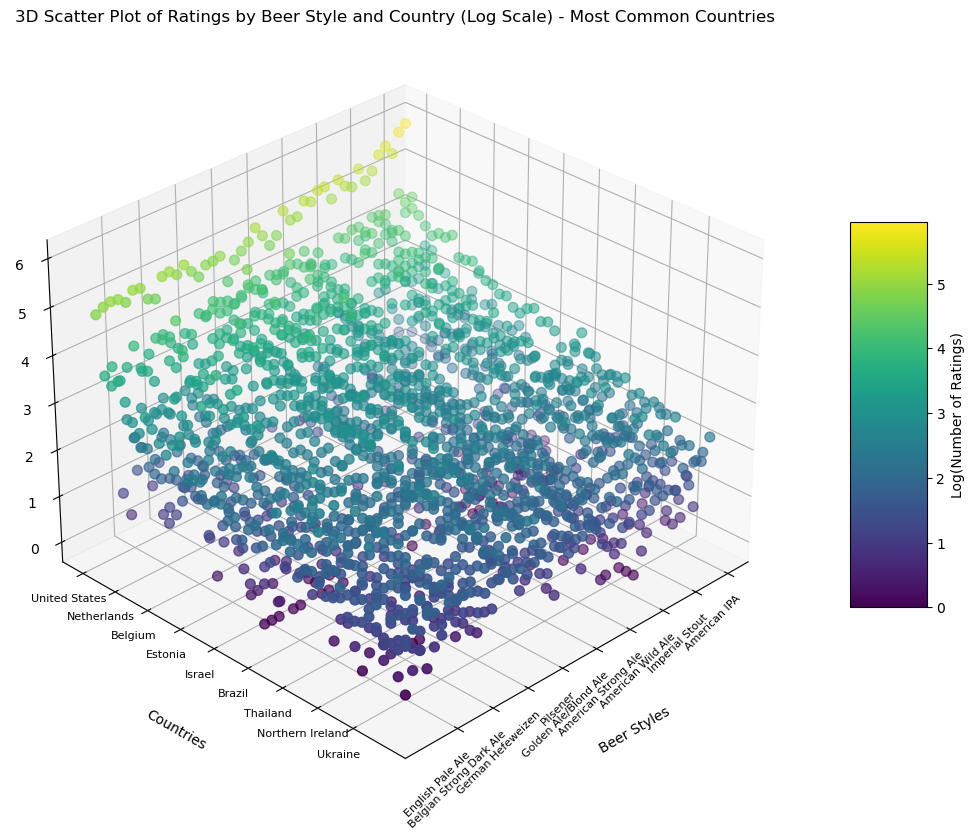

In [75]:
top_countries = merged_df.sum(axis=0).nlargest(45).index  # Sum ratings by country and select top 40
top_styles = merged_df.sum(axis=1).nlargest(45).index  # Sum ratings by style and select top 40

subset_df = merged_df.loc[top_styles, top_countries]


x_labels = subset_df.index        # Beer styles on the x-axis
y_labels = subset_df.columns      # Countries on the y-axis
x_pos, y_pos = np.meshgrid(range(len(x_labels)), range(len(y_labels)), indexing="ij")
z_values = subset_df.values       # Number of ratings on the z-axis

x_pos_flat = x_pos.flatten()
y_pos_flat = y_pos.flatten()
z_values_log_flat = np.log10(z_values.flatten() + 1)  # Log scale to handle large ranges

# Scatter plotting

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=45)
scatter = ax.scatter(x_pos_flat, y_pos_flat, z_values_log_flat, c=z_values_log_flat, cmap='viridis', s=50)
ax.set_xlabel('Beer Styles', labelpad=20)
ax.set_ylabel('Countries', labelpad=20)
ax.set_zlabel('Log(Number of Ratings)', labelpad=10)
ax.set_title('3D Scatter Plot of Ratings by Beer Style and Country (Log Scale) - Most Common Countries')

ax.set_xticks(np.arange(0, len(x_labels), 5))
ax.set_xticklabels(x_labels[::5], rotation=45, ha='right', fontsize=8)
ax.set_yticks(np.arange(0, len(y_labels), 5))
ax.set_yticklabels(y_labels[::5], fontsize=8)

cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Log(Number of Ratings)')

plt.show()

We will also use the time information to determine if regional beer style preferences are stable (which would suggest that they are strongly affected by culture)or if they vary over. Basically, we will use linear regression to see that beer style preferences are stable or not. To demonstrate that this is useful and feasible, we will analyze the some countries like U.S, Canada and England where we have enough data and the relatively same cultural habits to see time evolution of the ratings for the chosen beer styles.

In [128]:
data = total_ratings_loc_filtered[['style', 'user_location', 'rating','date']] # Choosing relavant columns
data.dropna(inplace=True) # Removing missing values

data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year  # Extract the year for trend analysis

agg_data = data.groupby(['user_location', 'style', 'year']).agg(   #Data by Year, Region, and Beer Style
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'size')   # Calculate the average rating per year, per region, and per beer style
).reset_index()

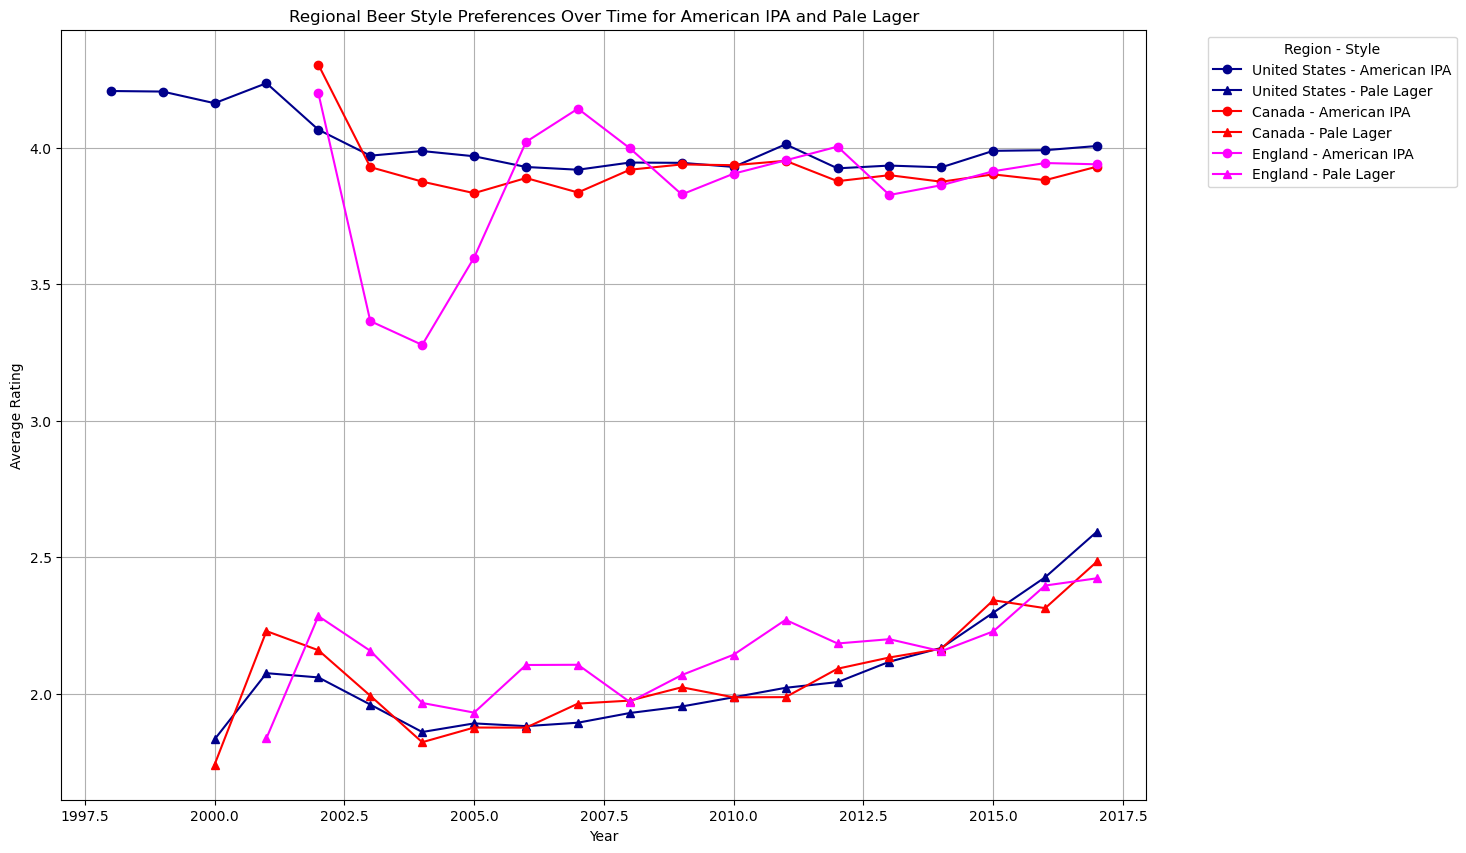

In [126]:
filtered_agg_data = agg_data[              # Filter `agg_data` to include only the selected regions and beer styles
    (agg_data['user_location'].isin(['United States', 'Canada', 'England'])) &
    (agg_data['style'].isin(['American IPA', 'Pale Lager']))
]

color_mapping = {'United States': 'darkblue','Canada': 'red','England': 'magenta'}
marker_mapping = {'American IPA': 'o','Pale Lager': '^' }

plt.figure(figsize=(14, 10))
for region in ['United States', 'Canada', 'England']:
    for style in ['American IPA', 'Pale Lager']:
        subset = filtered_agg_data[(filtered_agg_data['user_location'] == region) & (filtered_agg_data['style'] == style)]
        if len(subset) > 1:  # Ensure we have enough data points to plot a trend
            color = color_mapping[region]  
            marker = marker_mapping[style]     
            plt.plot(subset['year'], subset['avg_rating'], marker=marker, label=f'{region} - {style}', color=color, linestyle='-')

plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.title("Regional Beer Style Preferences Over Time for American IPA and Pale Lager")
plt.legend(title="Region - Style", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

For the sake of simplicity of the plot, since trends are obvious, we will not plot the linear models. First of all, average ratings show that American IPA is more preferable than Pale Lager in these three chosen countries. Time evolution of the average ratings reveals that American IPA ratings remain relatively stable for these three chosen country, suggesting a steady but not markedly increasing interest. Only in England, there is a significant deviation between the year 2000-2006. Interestingly, Pale Lager ratings in these three counts increase constantly over time. It suggests that there is a noticeable evolution in tastes over time, likely driven by global beer trends and expanding market availability, challenging the idea of stable, regionally bound beer preferences. More importantly, these patterns reveals that certain preferences may be culturally rooted because trends are really close to each other in U.S, Canada and England.

In [127]:
def calculate_trend(df): 
    X = df['year'].values.reshape(-1, 1)
    y = df['avg_rating'].values
    if len(X) > 1:  # Need more than one year to calculate trend
        model = LinearRegression()
        model.fit(X, y)
        trend = model.coef_[0] 
    else:
        trend = np.nan  # Not enough data to calculate trend
    return trend

trends = agg_data.groupby(['user_location', 'style']).apply(calculate_trend).reset_index(name='trend')
trends = filtered_agg_data.groupby(['user_location', 'style']).apply(calculate_trend).reset_index(name='trend')

trends

,user_location,style,trend
0,Canada,American IPA,-0.007611
1,Canada,Pale Lager,0.023907
2,England,American IPA,0.016012
3,England,Pale Lager,0.021224
4,United States,American IPA,-0.011967
5,United States,Pale Lager,0.028856


## b) Importance of specific beer attributes

In [67]:
# perform linear regression between attribute ratings the final rating for all countries together and compare coefficients for each attribute
# perform linear regression between attribute ratings the final rating for the different countries separately and observe the distribution of the coefficients for the different attributes across countries

We will now examine the importance of the different beer attributes in determining the final rating. 

To this aim, we will start by using linear regression with attribute ratings as features and the final rating as the outcome variable across all countries combined. We will then compare the coefficients of each attribute to evaluate their relative influence. After that, we will investigate how the importance of these attributes varies between countries by repeating this analysis separately for each country and examining the distribution of attribute coefficients across different countries.

To perform these analyses, we will attribute ratings data. Thus, we will start by removing reviews lacking one or several attribute rating values.

In [68]:
attributes = ['appearance', 'aroma', 'palate', 'taste'] 
ba_ratings_loc_filtered_no_missing= ba_ratings_loc_filtered.dropna(subset= attributes )
rb_ratings_loc_filtered_no_missing = rb_ratings_loc_filtered.dropna(subset= attributes )
rb_ratings_loc_filtered_no_missing.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location
0,33 Export (Gabon),410549.0,Sobraga,3198.0,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852.0,2.0,4.0,2.0,4.0,8.0,2.0,Poland,Gabon
1,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761.0,2.0,3.0,2.0,4.0,8.0,1.9,Spain,Gabon
2,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889.0,3.0,3.0,2.0,3.0,5.0,1.6,Poland,Gabon
3,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510.0,4.0,3.0,1.0,2.0,5.0,1.5,Spain,Gabon
4,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778.0,2.0,4.0,2.0,4.0,7.0,1.9,Germany,Gabon


We will now observe the distribution of each attribute ratings in the Beer Advocate and the Rate Beer datasets.

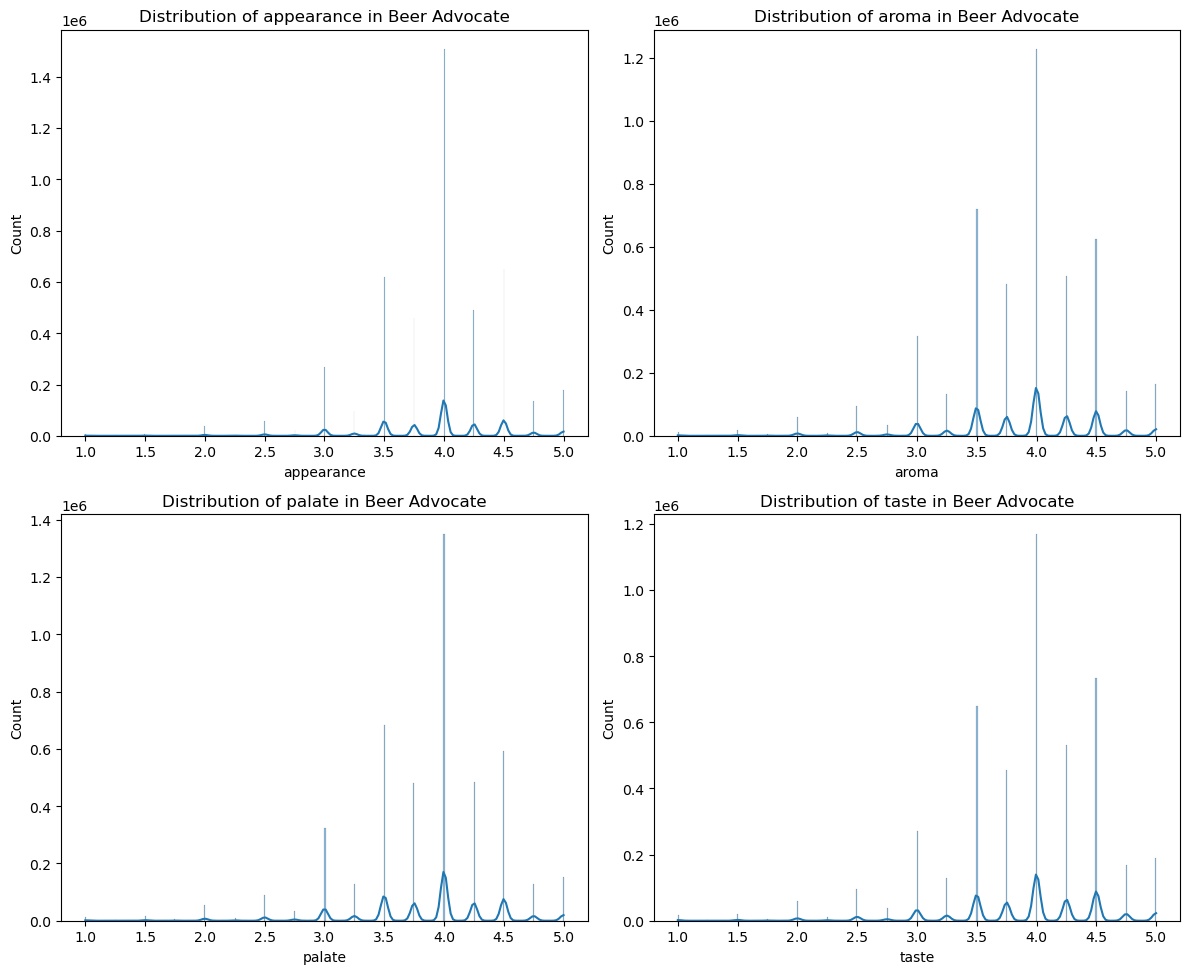

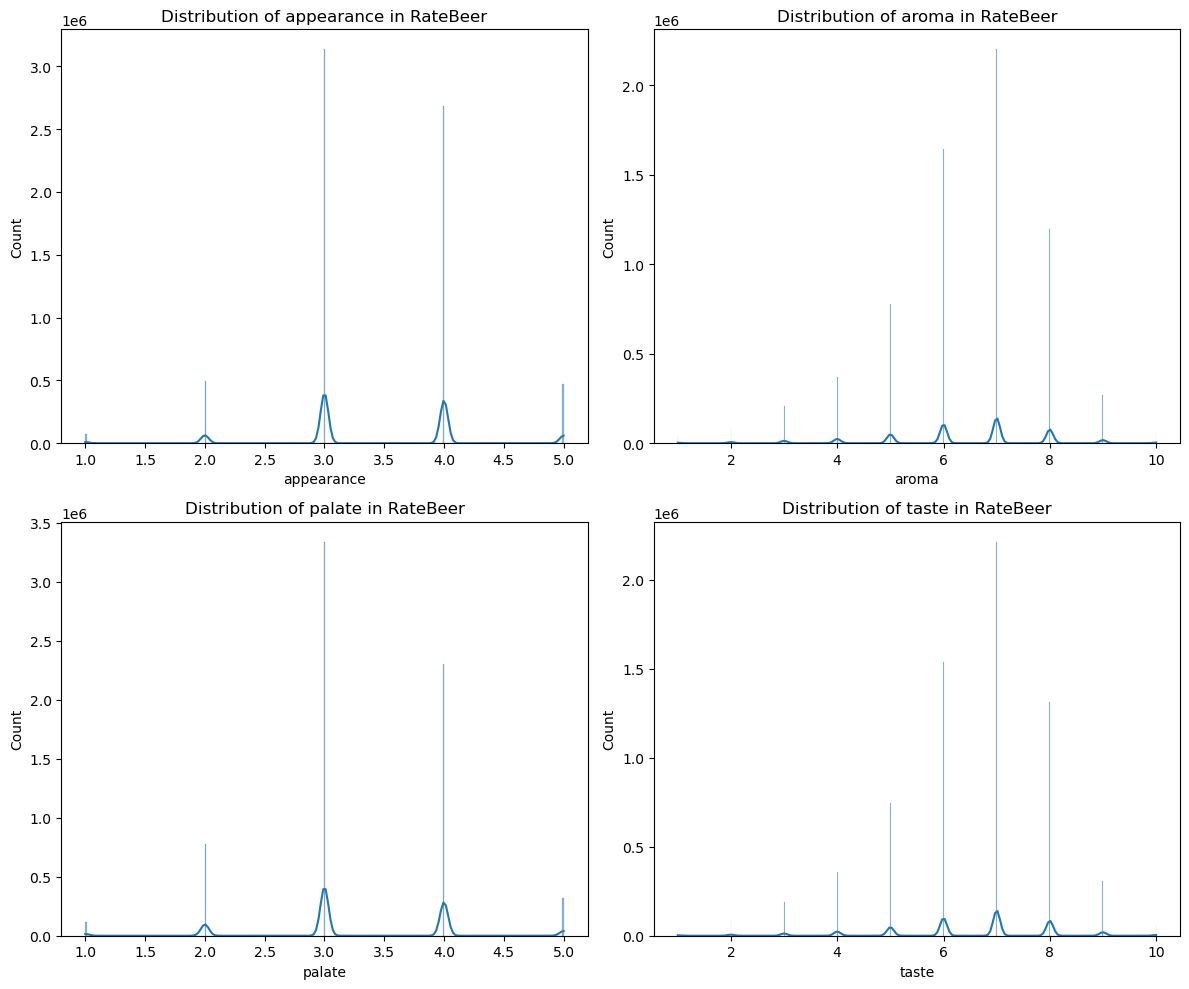

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, col in enumerate(attributes):
    sns.histplot(ba_ratings_loc_filtered_no_missing[col], kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f"Distribution of {col} in Beer Advocate")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, col in enumerate(attributes):
    sns.histplot(rb_ratings_loc_filtered_no_missing[col], kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f"Distribution of {col} in RateBeer")
plt.tight_layout()
plt.show()
plt.close()

Here we are looking at the general distribution of the beer atributes to get a gist of the ratings to differentiate between each attribute and what are the differences between the databases. Here we can see that the ratings in the Rate Beer are more harsh compared to the Beer Advocate and they are generally lower. Also to note that the taste and aroma ratings are given out of ten in Rate Beer , This can cause to some problems while concanating and doing correlation analysis.

In [70]:
rb_ratings_loc_filtered_no_missing['taste'] = rb_ratings_loc_filtered_no_missing['taste'] / 2
rb_ratings_loc_filtered_no_missing['aroma'] = rb_ratings_loc_filtered_no_missing['aroma'] / 2

Here we scaled the Rate Beer's taste and aroma beer attributes accordingly to the other attributes' rating scale so that we have a common scale. ( 5 point rating scale)

In [71]:
total_ratings_loc_filtered_no_missing = pd.concat([ba_ratings_loc_filtered_no_missing, rb_ratings_loc_filtered_no_missing], keys=['ba', 'rb']).reset_index(level=0).rename(columns={'level_0': 'source'})
total_ratings_loc_filtered_no_missing = total_ratings_loc_filtered_no_missing.reset_index(drop=True)
total_ratings_loc_filtered_no_missing.head()

,source,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location
0,ba,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 09:59:28,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,United States,Gabon
1,ba,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 10:59:12,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,United States,Northern Ireland
2,ba,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 10:59:12,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,Northern Ireland,Northern Ireland
3,ba,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 10:59:12,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Northern Ireland,Northern Ireland
4,ba,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 09:59:28,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,Northern Ireland,Northern Ireland


Here we concanated the two data frames together and added a source column so that we are not losing track of the origin of each rating.This data frame will be the main data frame for linear regression analysis as it will give us the total ratings

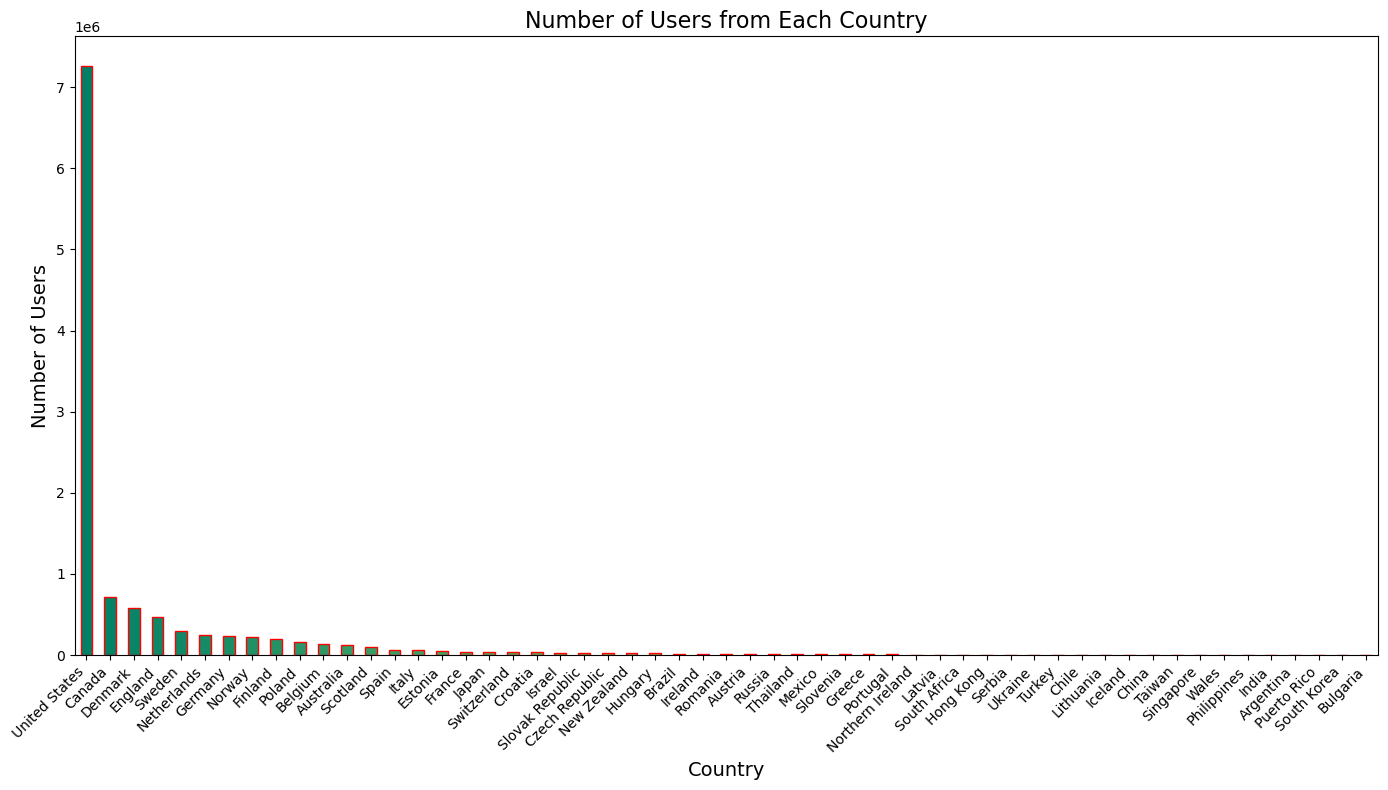

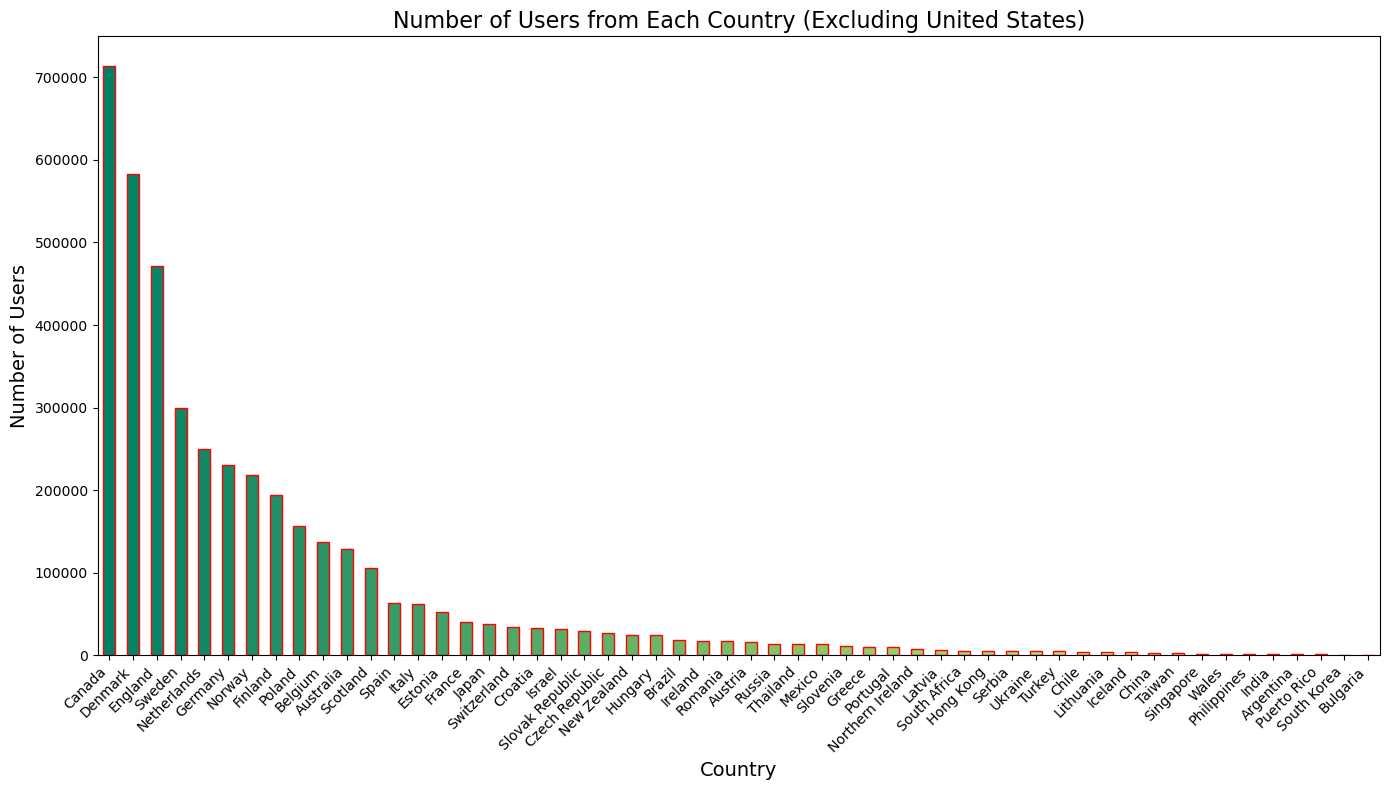

In [72]:
country_counts = total_ratings_loc_filtered_no_missing['user_location'].value_counts()
colors = plt.cm.summer(np.linspace(0, 1, len(country_counts)))
plt.figure(figsize=(14, 8))
country_counts.plot(kind='bar', color=colors, edgecolor='red')
plt.title("Number of Users from Each Country", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Number of Users", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  
plt.show()

usa_filtered_ratings = total_ratings_loc_filtered_no_missing[total_ratings_loc_filtered_no_missing['user_location'] != 'United States']

country_counts_without_usa= usa_filtered_ratings['user_location'].value_counts()

colors = plt.cm.summer(np.linspace(0, 1, len(country_counts)))

plt.figure(figsize=(14, 8))
country_counts_without_usa.plot(kind='bar', color=colors, edgecolor='red')
plt.title("Number of Users from Each Country (Excluding United States)", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Number of Users", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
plt.close()

Here we wanted to see how many users are coming from each country and plotted it by histograms to visualize it. We have two plots of histogram one with United States and one without it.This is because United States has much more user data compared to other countries so the histogram plots becomes a little bit skewed, so to get a better look at other countries contribution we made another plot without USA.

In [73]:
# We will try to see and compare how each attributes correlates between each other 
correlation_matrix_1 = ba_ratings_loc_filtered_no_missing[attributes].corr()

plt.figure(figsize=(5, 5)
sns.heatmap(correlation_matrix_1, annot=True, cmap="Greys")
plt.title("Correlation Matrix of different attributes in Beer Advocate")

correlation_matrix_2 = rb_ratings_loc_filtered_no_missing[attributes].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix_2, annot=True, cmap="Greens")
plt.title("Correlation Matrix of different attributes in Rate Beer")

correlation_matrix_total = total_ratings_loc_filtered_no_missing[attributes].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix_total, annot=True, cmap="Reds")
plt.title("Correlation Matrix of different attributes in Total Ratings")
plt.show()
plt.close()

SyntaxError: invalid syntax (2628019054.py, line 5)

Here we see the correlation matrix of each data frame, including the total ratings which is created by the concatanation of Rate Beer and Beer Advocate data frames. This matrix plot gives us a good information about the correalation between beer attributes and how the ratings differentiate between the data frames. We can see that in the Beer Advocate data frame taste aroma and palate attributes have a high correlation between each other while appearance also correlating to them but not as high. . In the Rate Beer data frame we see that aroma and taste correlates more between each other then with palate.Palate still correlates with them but not as strong as it was in Beer Advocate. The suprising finding here is that in the total ratings data frame, the combination of the two data frames gives us a stronger correlation between aroma and taste, while causing a remarkable drop of correlation of the palate attribute with them.These differences of correlation across each data frame indicate to us that the user profile of the two platforms have a distinct look on the attributes and their contribution to elavate each other.High correlation numbers between the attributes (especially the aroma and taste attributes) can be a sign of multicolineratiy which is important to take into account while doing the linear regression analyses.

In [129]:
beer_latvia = total_ratings_loc_filtered_no_missing[total_ratings_loc_filtered_no_missing['user_location'] == 'Latvia']
beer_latvia.sample(3)

,source,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location
6496859,rb,Brālis Bitter,244485.0,Brālis,5640.0,Bitter,5.3,2013-12-31 11:00:00,zenkis,175477.0,4.0,2.5,3.0,3.0,12.0,3.0,Latvia,Latvia
11369809,rb,Käbliku Rosalinda,430113.0,Käbliku Pruulikoda,23798.0,Saison,6.6,2016-07-15 09:59:28,Alusmamuts,231465.0,5.0,3.0,3.0,3.0,15.0,3.5,Latvia,Estonia
10869837,rb,De Bie Zatte Bie,7271.0,Brouwerij de Bie,1226.0,Belgian Strong Ale,9.0,2015-07-22 09:59:28,beermaris,367242.0,3.0,2.5,4.0,3.5,15.0,3.4,Latvia,Belgium


In [130]:
# Count the number of users from each country
country_counts_1 = total_ratings_loc_filtered_no_missing['user_location'].value_counts()

# Display the counts
print(country_counts_1)

user_location
United States       7264334
Canada               714098
Denmark              582586
England              471559
Sweden               299719
Netherlands          250117
Germany              229950
Norway               218457
Finland              193871
Poland               155965
Belgium              136486
Australia            128331
Scotland             105410
Spain                 62959
Italy                 61901
Estonia               52673
France                40612
Japan                 37206
Switzerland           33647
Croatia               33329
Israel                31638
Slovak Republic       29401
Czech Republic        26648
New Zealand           24883
Hungary               24747
Brazil                18247
Ireland               17305
Romania               16617
Austria               15998
Russia                14046
Thailand              13272
Mexico                13238
Slovenia              10476
Greece                 9961
Portugal               9523
Northe

In [131]:
X_latvia = beer_latvia[attributes]
display(X_latvia)
y_latvia = beer_latvia['rating']
display(y_latvia)
results =advanced_linear_regression(X_latvia,y_latvia)
display(results)

,appearance,aroma,palate,taste
14118,3.50,3.50,2.50,2.50
21931,3.75,4.50,3.75,3.75
24999,3.50,4.25,4.00,4.00
25627,4.00,4.50,3.75,4.00
26142,4.00,4.25,3.50,3.75
...,...,...,...,...
11411406,2.00,1.00,1.00,1.00
11411489,3.00,3.00,2.00,1.50
11411534,2.00,1.00,2.00,1.00
11411536,3.00,2.00,1.00,2.50


14118       2.90
21931       3.93
24999       4.03
25627       4.10
26142       3.86
            ... 
11411406    1.20
11411489    2.20
11411534    1.40
11411536    2.30
11413083    2.80
Name: rating, Length: 6393, dtype: float64

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 1.559e+04
Date:                Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:00:46   Log-Likelihood:                 1517.2
No. Observations:                4475   AIC:                            -3024.
Df Residuals:                    4470   BIC:                            -2992.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3447      0.003   1297.137      0.0

NameError: name 'plt' is not defined

In [135]:
beer_usa = total_ratings_loc_filtered_no_missing[total_ratings_loc_filtered_no_missing['user_location'] == 'United States']
beer_usa.sample(3)

,source,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location
7302012,rb,Almanac Spring 2012 Biere de Mars,172186.0,Almanac Beer Company,13058.0,Bière de Garde,7.0,2015-03-29 09:59:28,Ernesto987,119773.0,4.0,2.5,3.0,3.00,11.00,2.90,United States,United States
9469384,rb,Odd Side Ales Hipster Brunch Stout,301603.0,Odd Side Ales,11793.0,Imperial Stout,10.0,2016-09-02 09:59:28,bwa5879,134519.0,5.0,3.5,5.0,4.00,16.00,4.10,United States,United States
3093432,ba,Richard's Double Black EyePA,133428.0,Double Barley Brewing,33065.0,American Black Ale,8.2,2015-05-19 09:59:28,thehooksman,thehooksman.583418,5.0,4.0,4.0,3.75,4.25,4.01,United States,United States


In [136]:
X_usa = beer_usa[attributes]
display(X_usa)
y_usa = beer_usa['rating']
display(y_usa)
results_u =advanced_linear_regression(X_usa,y_usa)
display(results_u)

,appearance,aroma,palate,taste
0,3.25,2.75,3.25,2.75
1,3.00,3.50,3.50,4.00
5,4.25,4.50,3.25,3.75
6,4.00,3.75,3.50,3.50
7,3.00,3.50,2.50,2.50
...,...,...,...,...
11413501,3.00,1.00,2.00,1.00
11413502,2.00,2.00,2.00,2.00
11413513,2.00,2.50,2.00,2.50
11413515,3.00,3.00,2.00,2.50


0           2.88
1           3.67
5           3.91
6           3.64
7           2.77
            ... 
11413501    1.20
11413502    2.00
11413513    2.40
11413515    2.60
11413518    1.90
Name: rating, Length: 7264334, dtype: float64

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 4.367e+07
Date:                Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:01:47   Log-Likelihood:             3.8906e+06
No. Observations:             5085033   AIC:                        -7.781e+06
Df Residuals:                 5085028   BIC:                        -7.781e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6830   4.99e-05   7.38e+04      0.0

NameError: name 'plt' is not defined

# 2) Location-related biases in ratings

## a) Cultural biases

In [137]:
# determine the final rating for each country/ geographic area
# determine if the final rating for each country/ geographic area is the same using statistical tests

In this part, we aim at determining whether users from certain countries are more generous or more critical in their ratings compared to users from other countries. To do so, we will calculate the final rating for each country and use statistical tests to determine if the final rating is the same or not for each country.

We first calculate the average rating for each country.

In [138]:
# Calculate average final rating for each country in BeerAdvocate
ba_country_avg_rating = ba_ratings_loc_filtered.groupby('brewery_location')['rating'].mean().reset_index()
ba_country_avg_rating.columns = ['brewery_location', 'average_rating']

# Calculate average final rating for each country in RateBeer
rb_country_avg_rating = rb_ratings_loc_filtered.groupby('brewery_location')['rating'].mean().reset_index()
rb_country_avg_rating.columns = ['brewery_location', 'average_rating']

In [139]:
# Print the average ratings for each country
print("BeerAdvocate - Average Rating by Country")
print(ba_country_avg_rating.head(5))
print("\nRateBeer - Average Rating by Country")
print(rb_country_avg_rating.head(5))

BeerAdvocate - Average Rating by Country
    brewery_location  average_rating
0            Albania        3.110625
1            Algeria        2.548235
2            Andorra        3.160000
3             Angola        2.316667
4  Antigua & Barbuda        2.897826

RateBeer - Average Rating by Country
  brewery_location  average_rating
0         Abkhazia        1.919231
1          Albania        2.112303
2          Algeria        1.761972
3          Andorra        2.562319
4           Angola        1.775221


In [140]:
# Calculate top 10 and least 10 countries by average rating for BeerAdvocate
ba_top_10 = ba_country_avg_rating.nlargest(10, 'average_rating')
ba_least_10 = ba_country_avg_rating.nsmallest(10, 'average_rating')


In [141]:
# Calculate top 10 and least 10 countries by average rating for RateBeer
rb_top_10 = rb_country_avg_rating.nlargest(10, 'average_rating')
rb_least_10 = rb_country_avg_rating.nsmallest(10, 'average_rating')


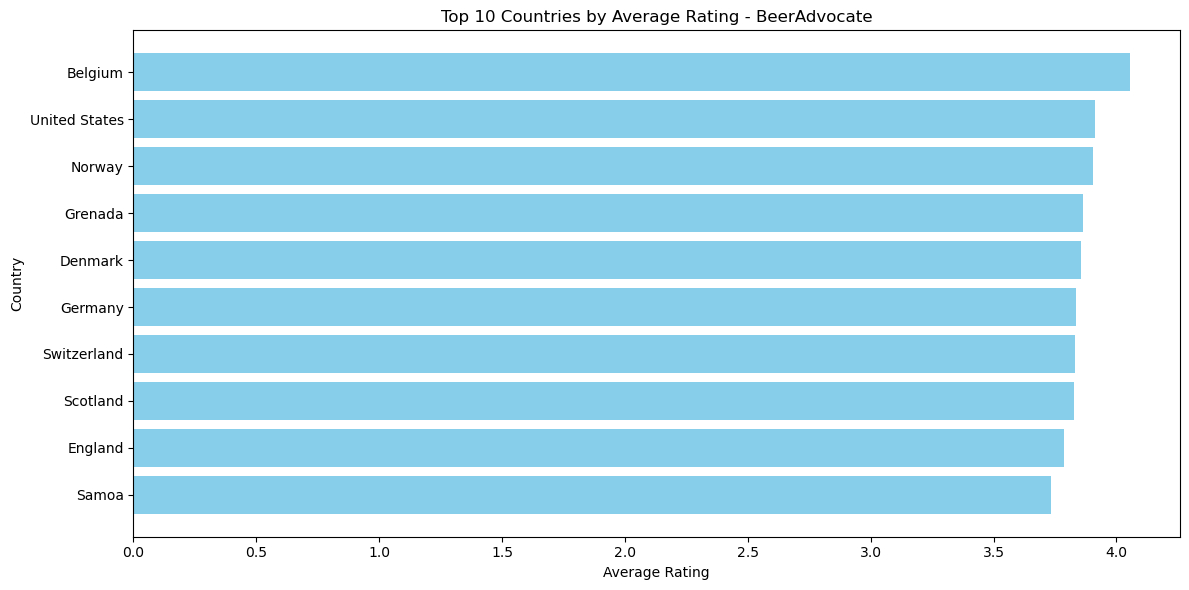

In [142]:
# Plot Top 10 Countries by Average Rating - BeerAdvocate
plt.figure(figsize=(12, 6))
plt.barh(ba_top_10['brewery_location'], ba_top_10['average_rating'], color='skyblue')
plt.title("Top 10 Countries by Average Rating - BeerAdvocate")
plt.xlabel("Average Rating")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

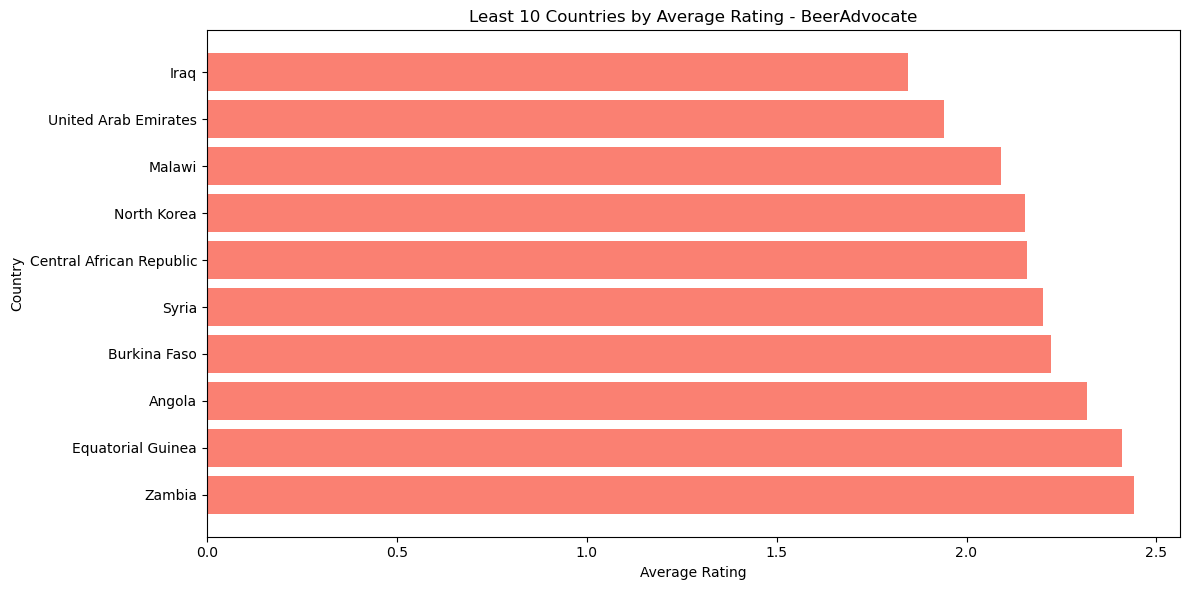

In [143]:
# Plot Least 10 Countries by Average Rating - BeerAdvocate
plt.figure(figsize=(12, 6))
plt.barh(ba_least_10['brewery_location'], ba_least_10['average_rating'], color='salmon')
plt.title("Least 10 Countries by Average Rating - BeerAdvocate")
plt.xlabel("Average Rating")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

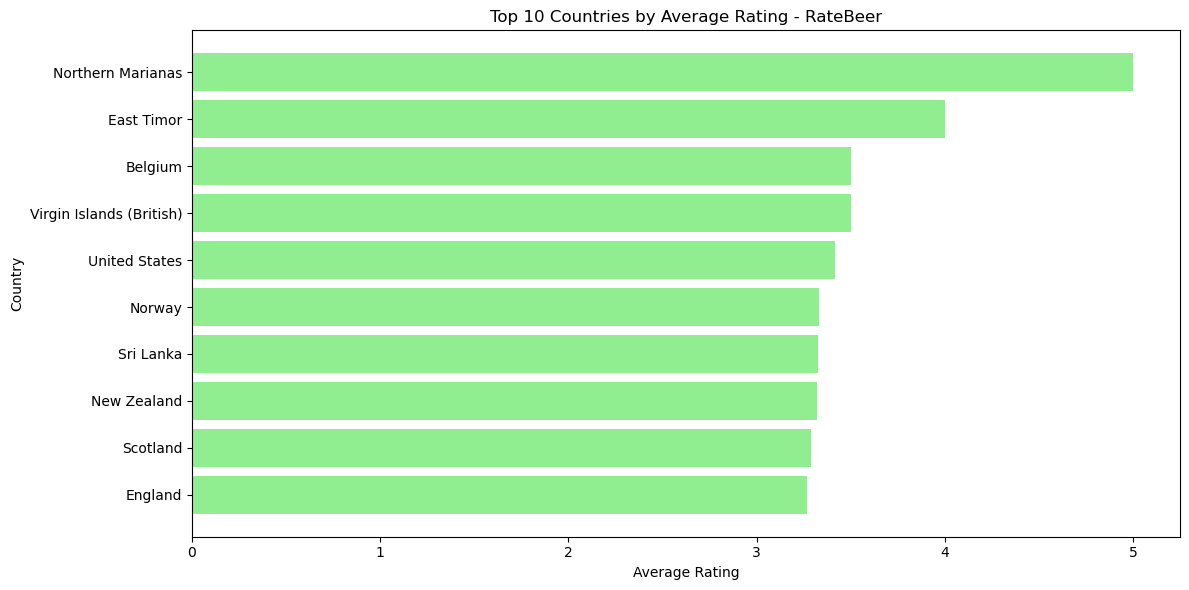

In [144]:
# Plot Top 10 Countries by Average Rating - RateBeer
plt.figure(figsize=(12, 6))
plt.barh(rb_top_10['brewery_location'], rb_top_10['average_rating'], color='lightgreen')
plt.title("Top 10 Countries by Average Rating - RateBeer")
plt.xlabel("Average Rating")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

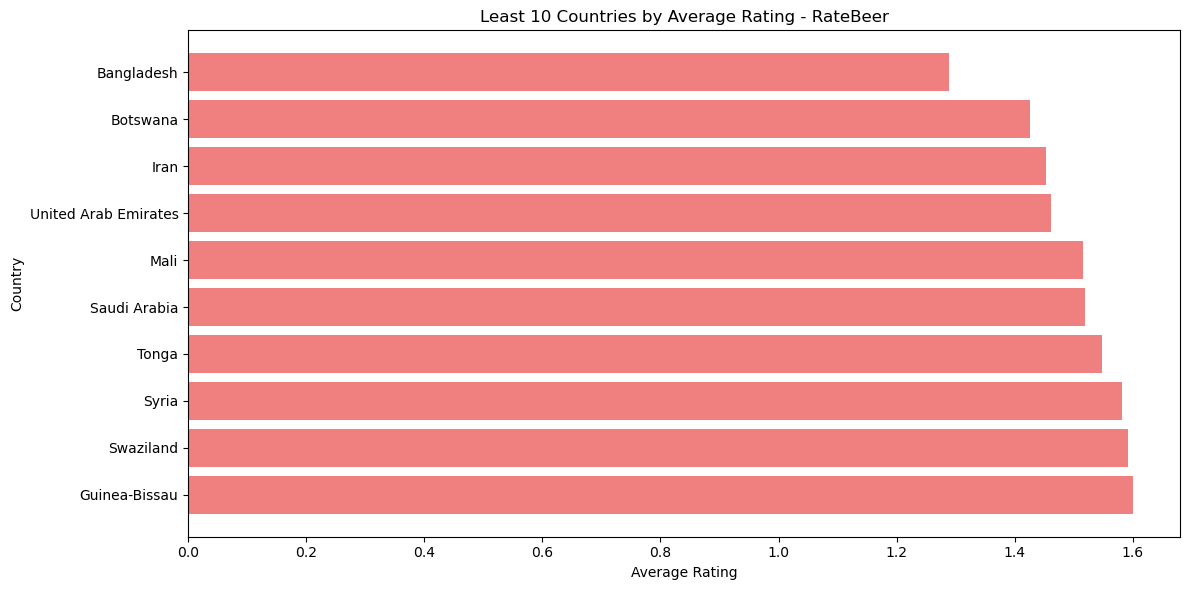

In [145]:
# Plot Least 10 Countries by Average Rating - RateBeer
plt.figure(figsize=(12, 6))
plt.barh(rb_least_10['brewery_location'], rb_least_10['average_rating'], color='lightcoral')
plt.title("Least 10 Countries by Average Rating - RateBeer")
plt.xlabel("Average Rating")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

On BeerAdvocate, countries like Scotland, Belgium, and the United States rank among the top 10, with high average ratings. We conclude that the trend aligns with these countries' rich brewing traditions and strong cultural associations with beer, and it possibly leads to more favorable reviews. We observed similar patterns on RateBeer, with high ratings for Belgium and the United States, also with additional entries like the Northern Marianas and East Timor. Some regions in the top 10 (such as Virgin Islands and Norway) may not be widely known for their beer culture but might have high ratings due to a small number of highly rated, niche beers that stand out. Countries like Belgium and Germany, who are known for quality beer production, supports the idea that culturally significant beer-producing nations receive high average ratings. 


In contrast, countries in the least 10 average ratings—such as Iraq, United Arab Emirates, and North Korea on BeerAdvocate, and countries like Bangladesh, Botswana, and Iran on RateBeer are often places where alcohol consumption is culturally or legally restricted. This could limit the variety and quality of beers available, and contributes to lower average ratings. The countries with fewer cultural connections to beer brewing suggests that limited beer exposure or lower availability may result in more critical reviews, or that the available beers do not meet the quality expectations of users.

We will use an ANOVA test to check if there are significant differences in the average ratings between different geographic areas. This test is feasible when we compare averages between multiple groups. The ANOVA test will return an F-statistic and a p-value. If the p-value is below a significance level, we can conclude that there are statistically significant differences in the ratings between countries.

In [146]:
# Gather ratings by location for BeerAdvocate
ba_ratings_by_location = [group['rating'].values for _, group in ba_ratings_loc_filtered.groupby('brewery_location')]

# Perform ANOVA test for BeerAdvocate
ba_anova_result = f_oneway(*ba_ratings_by_location)
print("BeerAdvocate ANOVA test result:", ba_anova_result)

# Gather ratings by location for RateBeer
rb_ratings_by_location = [group['rating'].values for _, group in rb_ratings_loc_filtered.groupby('brewery_location')]

# Perform ANOVA test for RateBeer
rb_anova_result = f_oneway(*rb_ratings_by_location)
print("RateBeer ANOVA test result:", rb_anova_result)


BeerAdvocate ANOVA test result: F_onewayResult(statistic=2153.9121560862914, pvalue=0.0)
RateBeer ANOVA test result: F_onewayResult(statistic=3526.440733301745, pvalue=0.0)


The ANOVA test results for BeerAdvocate and RateBeer show that there are significant differences in average beer ratings across countries. Both tests produced very high F-statistics, around 2026.50 for BeerAdvocate and 3526.44 for RateBeer, with p-values of 0. This means it’s extremely unlikely that these results happened by chance, so we can reject the null hypothesis that the average ratings are the same in each country. This suggests that people from different countries rate beers differently, likely due to cultural or regional preferences.

To better understand rating behaviors across different countries, we can analyze the number of ratings and reviews submitted by users from each location. This will help us identify if some regions have more active rating communities than others. If certain countries have significantly higher levels of activity, it could impact the overall ratings on the platform, potentially creating biases that reflect the preferences of the most active user groups. By examining both the total activity and the average ratings and reviews per user in each country, we can get a clearer picture of how regional differences might influence beer ratings.

In [147]:
#for beer advocate

#Calculate total ratings and reviews by country
user_activity_totals = ba_users_loc_filtered.groupby('location')[['nbr_ratings', 'nbr_reviews']].sum().reset_index()
user_activity_totals.columns = ['Country', 'Total Ratings', 'Total Reviews']
user_activity_totals_sorted = user_activity_totals.sort_values(by=['Total Ratings', 'Total Reviews'], ascending=False)

# Display total activity levels by country
print("Total User Activity by Country")
print(user_activity_totals_sorted)

Total User Activity by Country
             Country  Total Ratings  Total Reviews
51     United States        7303870        2241334
6             Canada         274512         126591
12           England          41597          21017
1          Australia          34915          25947
45            Sweden          29914           9067
29       Netherlands          22952           9740
16           Germany          17460           8234
36           Romania          16823           3490
3            Belgium          16478           4053
37            Russia          10521           2218
44             Spain           9585           4108
4             Brazil           8628           1025
38          Scotland           7382           3948
28            Mexico           6500           3816
22           Ireland           6207           1212
25             Japan           6151           2685
15            France           6135           3605
24             Italy           5930           2998


In [148]:
# for ratebeer
user_activity_totals_rb = rb_users_loc_filtered.groupby('location')[['nbr_ratings']].sum().reset_index()
user_activity_totals_rb.columns = ['Country', 'Total Ratings']
user_activity_totals_rb_sorted = user_activity_totals_rb.sort_values(by='Total Ratings', ascending=False)

# Display total activity levels by country for RateBeer
print("Total User Activity by Country (RateBeer)")
print(user_activity_totals_rb_sorted)

Total User Activity by Country (RateBeer)
             Country  Total Ratings
53     United States        3274619
11           Denmark         633814
6             Canada         546493
12           England         465714
47            Sweden         305113
29       Netherlands         263071
16           Germany         238709
32            Norway         231676
34            Poland         207299
14           Finland         205541
3            Belgium         136598
1          Australia         106167
39          Scotland         105693
46             Spain          61230
24             Italy          60541
13           Estonia          58004
15            France          38485
9            Croatia          35313
25             Japan          34699
23            Israel          34581
48       Switzerland          33000
42   Slovak Republic          32383
10    Czech Republic          27678
30       New Zealand          26949
19           Hungary          26665
2            Austria  

In [149]:
#for beer advocate

#Calculate average ratings and reviews per user by country
user_activity_averages = ba_users_loc_filtered.groupby('location')[['nbr_ratings', 'nbr_reviews']].mean().reset_index()
user_activity_averages.columns = ['Country', 'Average Ratings per User', 'Average Reviews per User']
user_activity_averages_sorted = user_activity_averages.sort_values(by=['Average Ratings per User', 'Average Reviews per User'], ascending=False)

# Display average activity levels per user by country
print("\nAverage User Activity per User by Country")
print(user_activity_averages_sorted)


Average User Activity per User by Country
             Country  Average Ratings per User  Average Reviews per User
36           Romania                267.031746                 55.396825
30  Northern Ireland                132.500000                 97.590909
45            Sweden                 97.123377                 29.438312
48          Thailand                 91.555556                 43.666667
2            Austria                 88.148148                 19.333333
29       Netherlands                 84.693727                 35.940959
6             Canada                 82.584838                 38.083935
38          Scotland                 73.820000                 39.480000
3            Belgium                 72.590308                 17.854626
1          Australia                 67.144231                 49.898077
51     United States                 64.508713                 19.795748
46       Switzerland                 64.274194                 23.338710
50      

In [150]:
# for rate beer
user_activity_averages_rb = rb_users_loc_filtered.groupby('location')[['nbr_ratings']].mean().reset_index()
user_activity_averages_rb.columns = ['Country', 'Average Ratings per User']
user_activity_averages_rb_sorted = user_activity_averages_rb.sort_values(by='Average Ratings per User', ascending=False)

print("Average User Activity per User by Country (RateBeer)")
print(user_activity_averages_rb_sorted)

Average User Activity per User by Country (RateBeer)
             Country  Average Ratings per User
11           Denmark                614.756547
14           Finland                454.736726
23            Israel                443.346154
13           Estonia                432.865672
42   Slovak Republic                348.204301
32            Norway                344.755952
47            Sweden                303.897410
25             Japan                294.059322
39          Scotland                279.611111
16           Germany                267.911336
50          Thailand                264.829787
29       Netherlands                240.247489
9            Croatia                227.825806
10    Czech Republic                183.298013
12           England                170.341624
6             Canada                167.893395
48       Switzerland                165.829146
18         Hong Kong                145.531250
3            Belgium                133.006816
2      

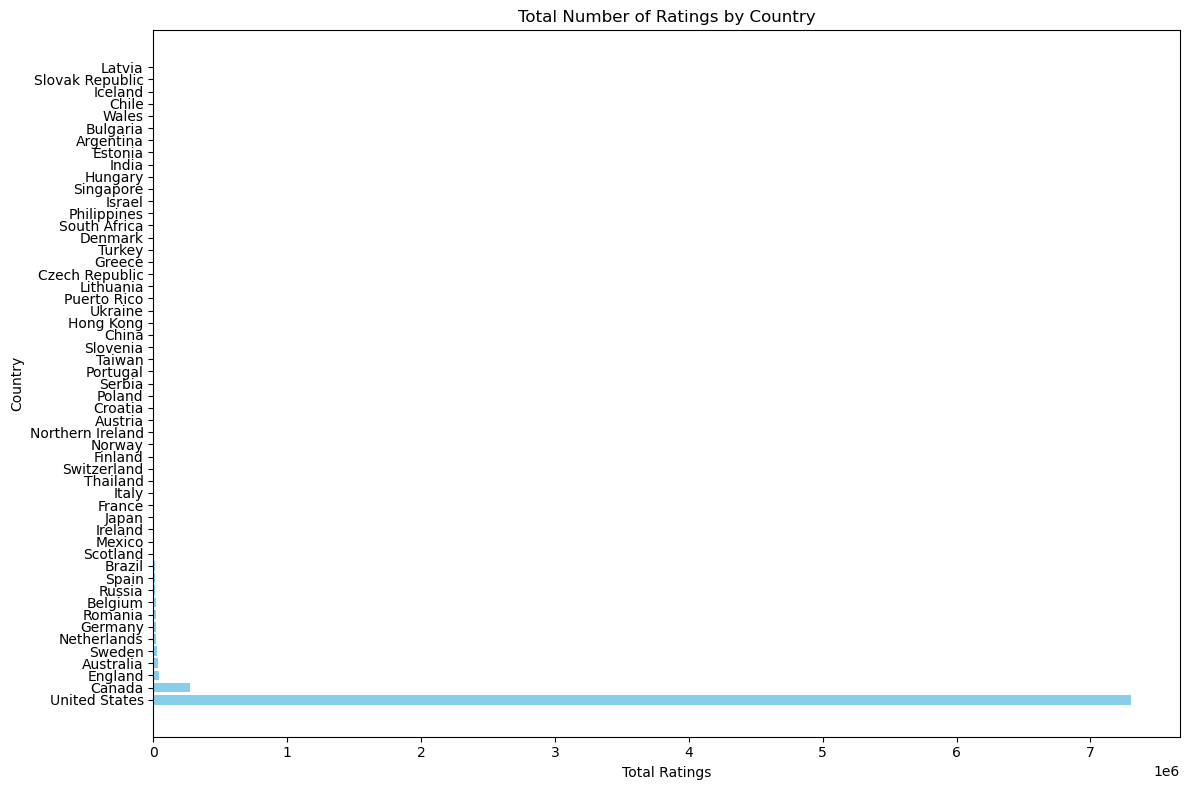

In [151]:
# Plot Total Ratings by Country 
user_activity_totals_sorted = user_activity_totals.sort_values(by='Total Ratings', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(user_activity_totals_sorted['Country'], user_activity_totals_sorted['Total Ratings'], color='skyblue')
plt.title("Total Number of Ratings by Country")
plt.xlabel("Total Ratings")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


As we have a large disparity in the values, US has a lot of ratings and this does not give us a good display of the data. Therefore, we will use a logarithmic scale . In this way, we can compare countries with few ratings to countries with very high ratings.  

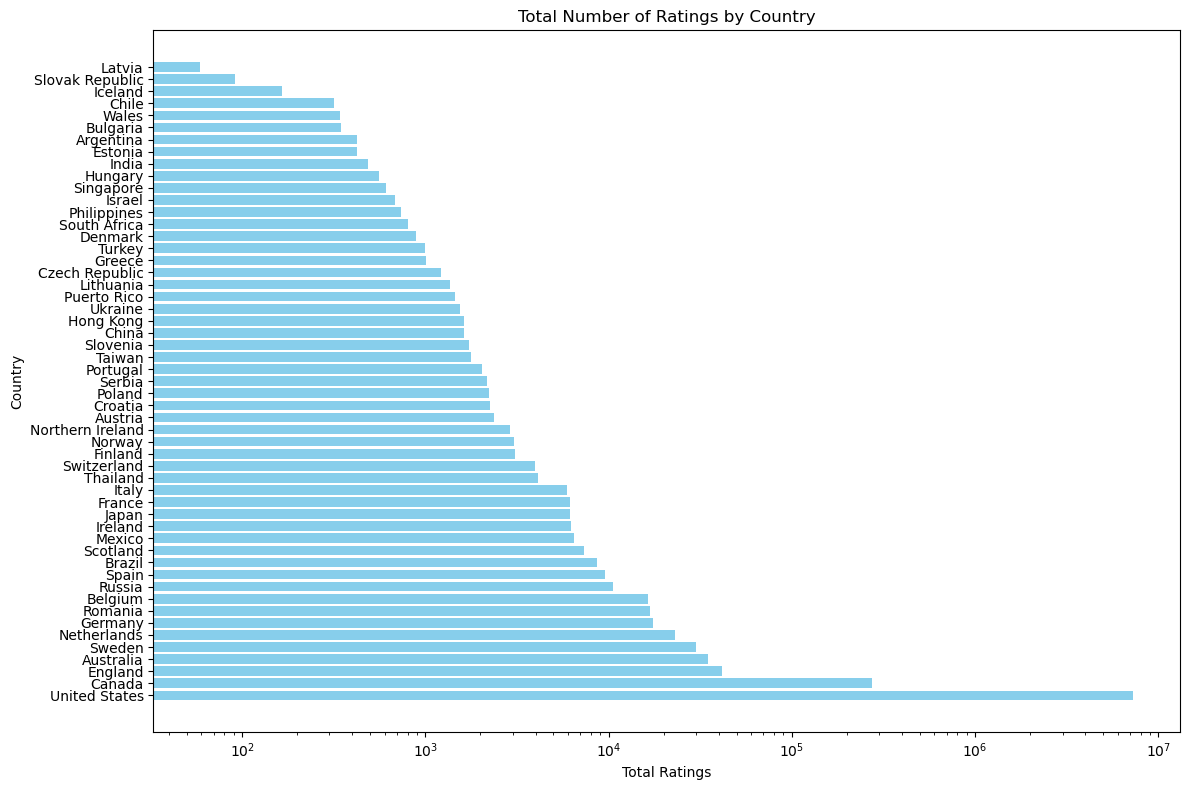

In [152]:
user_activity_totals_sorted = user_activity_totals.sort_values(by='Total Ratings', ascending=False)
# Plot Total Ratings by Country with sorted values and a logarithmic scale
plt.figure(figsize=(12, 8))
plt.barh(user_activity_totals_sorted['Country'], user_activity_totals_sorted['Total Ratings'], color='skyblue')
plt.title("Total Number of Ratings by Country")
plt.xlabel("Total Ratings")
plt.ylabel("Country")
plt.xscale('log')
plt.tight_layout()
plt.show()


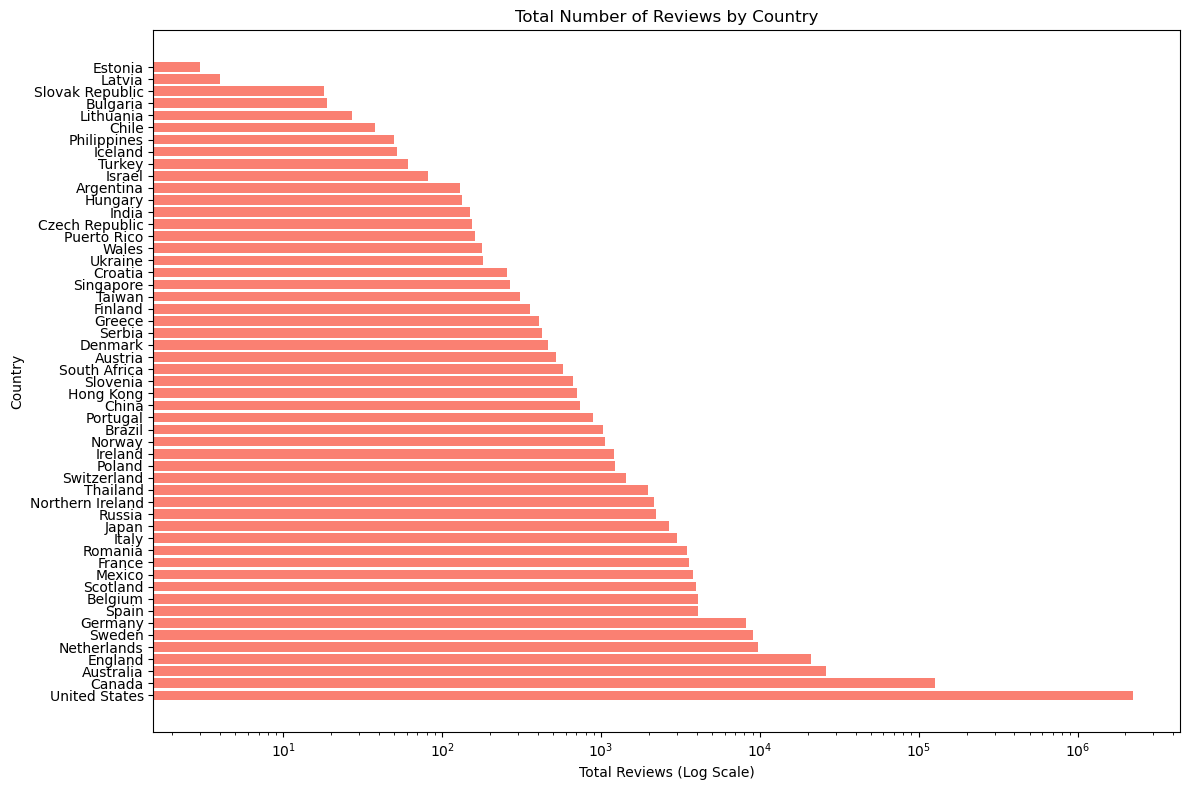

In [153]:
# Sort user_activity_totals by 'Total Reviews' in descending order
user_activity_totals_sorted = user_activity_totals.sort_values(by='Total Reviews', ascending=False)

# Plot Total Reviews by Country with a logarithmic scale
plt.figure(figsize=(12, 8))
plt.barh(user_activity_totals_sorted['Country'], user_activity_totals_sorted['Total Reviews'], color='salmon')
plt.title("Total Number of Reviews by Country")
plt.xlabel("Total Reviews (Log Scale)")
plt.ylabel("Country")
plt.xscale('log')
plt.tight_layout()
plt.show()

The analysis of rating behaviors across different countries suggests that certain regions have much higher levels of activity on the platform. Countries like the United States and Canada, also some European nations, contribute the majority of ratings and reviews. This high activity means that these countries’ preferences are more likely to dominate the overall ratings, and we could most possible have a cultural bias. For instance, if users in the United States tend to favor specific types of beers, those beers might receive higher average ratings on the platform, while beers that are popular in less active regions could be undervalued. The high volume of reviews from these active countries might not fully represent global preferences, which can impact how users perceive the ratings.


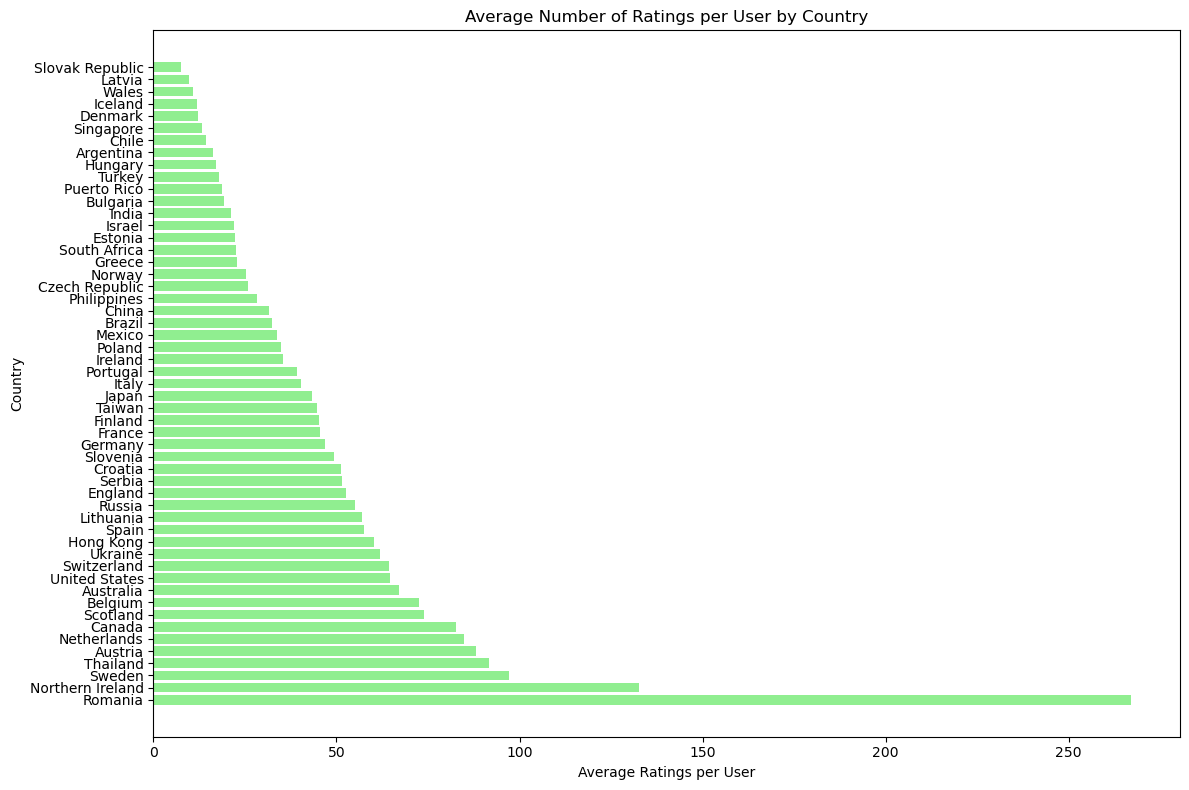

In [154]:
# Average Ratings per User by Country
user_activity_averages_sorted = user_activity_averages.sort_values(by='Average Ratings per User', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(user_activity_averages_sorted['Country'], user_activity_averages_sorted['Average Ratings per User'], color='lightgreen')
plt.title("Average Number of Ratings per User by Country")
plt.xlabel("Average Ratings per User")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

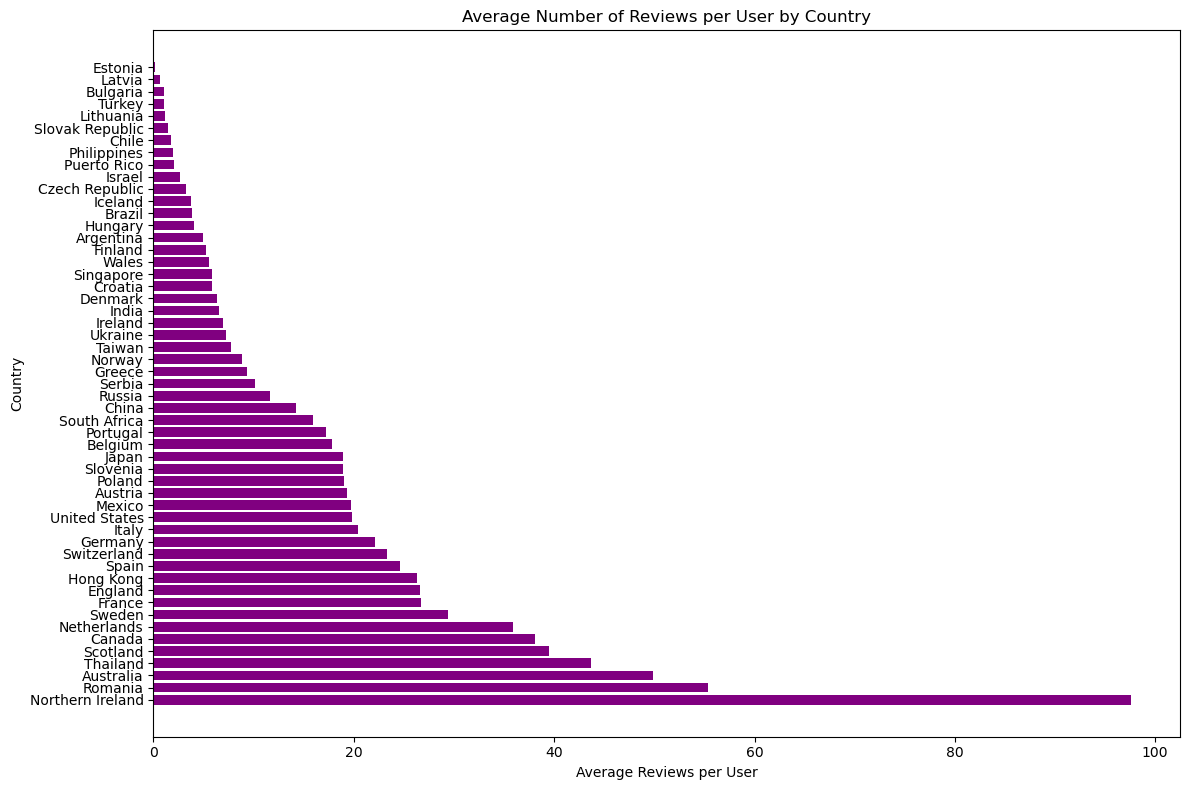

In [155]:
# Average Reviews per User by Country
user_activity_averages_sorted = user_activity_averages.sort_values(by='Average Reviews per User', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(user_activity_averages_sorted['Country'], user_activity_averages_sorted['Average Reviews per User'], color='purple')
plt.title("Average Number of Reviews per User by Country")
plt.xlabel("Average Reviews per User")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

We observed that some countries have higher average ratings and reviews per user. This means that users from certain regions are more active overall and also more engaged individually, they often contribute more reviews per person. We state that this engagement increases the influence of these countries on the platform’s ratings.  For example, users from Northern Ireland or Romania, who show high average reviews per user, prefer strong, dark beers, their frequent reviews could increase the ratings of these beer styles. As a result, the overall beer ratings may reflect the tastes and biases of the most active user groups rather than providing a balanced view of global preferences.

## b) Beer origin bias

In [156]:
# compare the final rating of domestic vs foreign beers and determine if there is a significant difference using statistical tests

# IMPORTANT NOTE: for the following task, do the following:
# 1) for each rating dataframe, perform a value_count on the 'user_location' column: the values correspond to countries that we considered to have enough reviewers
# 2) create a copy of the beer dataframes to remove beers whose brewerie is not in one of the countries identified above
# task in question: determine if the final rating of a given beer is correlated with the number of reviewers from the country where the beer comes from who reviewed that beer (scatter plot + Pearson’s correlation coefficient + regression)

# isolate beer enthusiasts (who wrote a very large number of reviews) and compare the final rating of domestic vs foreign beers and determine if there is a significant difference using statistical tests

In this part, we will investigate whether users rate domestic beers higher than foreign ones. 

To this aim, we will compare the final ratings of domestic versus foreign beers and use statistical tests to determine if the difference is significant. We will do this analysis considering all countries together at first, then considering countries separately.

To further investigate this potential bias, we will analyze whether the final rating of a beer correlates with the number of reviewers from the beer's country of origin by employing scatter plots and Pearson’s correlation coefficient. We will also use linear regression to see if the number of reviewers from the beer's country of origin is useful to explain the final rating of a beer. 

We will also compare the final ratings of domestic versus foreign beers considering all countries together but this time focusing only on beer enthusiasts—users who have written a substantial number of reviews—who might prioritize intrinsic qualities of the beers over external factors such as location.

We will perform the analysis described above for P3. For P2, we will simply verify the feasibility of the analysis. 

To verify that the analysis considering countries separately is feasible, we will verify that we have enough countries such that:
- there are enough reviews from users from that country rating a beer from the same country
- there are enough reviews from users from that country rating a beer from a different country.
Let us decide arbitrarily that 'enough reviews' in this context means at least 10 reviews.

Let us determine how many countries meet these criteria.

In this analysis, we will combine the data from the 2 review platforms.

In [157]:
# combine Beer Advocate and Rate Beer rating dataframes
ba_rb_combined = pd.concat([ba_ratings_loc_filtered, rb_ratings_loc_filtered], ignore_index=True)

In [158]:
REVIEW_NB_THESHOLD = 10

# count occurrences where 'brewerie_location' is equal to 'user_location'
equal_counts = ba_rb_combined[ba_rb_combined['brewery_location'] == ba_rb_combined['user_location']]['user_location'].value_counts()

# count occurrences where 'brewerie_location' is different from 'user_location'
different_counts = ba_rb_combined[ba_rb_combined['brewery_location'] != ba_rb_combined['user_location']]['user_location'].value_counts()

# identify 'user_location' values that meet both conditions (>=10 for both equal and different cases)
usable_user_locations = equal_counts[equal_counts >= REVIEW_NB_THESHOLD].index.intersection(different_counts[different_counts >= REVIEW_NB_THESHOLD].index)

# keep only reviews where 'user_location' is in the valid list
ba_rb_combined_filtered = ba_rb_combined[ba_rb_combined['user_location'].isin(usable_user_locations)]

print('Number of countries meeting the criteria:',ba_rb_combined_filtered['user_location'].nunique())

Number of countries meeting the criteria: 55


55 countries meet the criteria described above, which seems enough to perform our analysis for P3.

Since we will also perform an analysis considering all countries together but focusing only on beer enthusiasts, we also need to verify that there are enough beer enthusiasts in the combined rating DataFrame. We will consider that a user is a beer enthusiast if they have posted at least 50 reviews.

In [159]:
ENTHUSIAST_THRESHOLD = 50

# calculate the counts of each 'user_id' in the combined review dataframe
user_counts = ba_rb_combined['user_id'].value_counts()

# keep only user_id values that appear at least 50 times
beer_enthusiasts = user_counts[user_counts >= ENTHUSIAST_THRESHOLD].index.tolist()

print("Number of beer enthusiasts:",len(beer_enthusiasts))

Number of beer enthusiasts: 27977


There are nearly 28 thousand beer enthusiasts in the DataFrame, which seems enough to perform our analysis for P3.

# 3) Other biases

## a) Seasonal biases

In [160]:
# use the time information to determine the season during which each rating was posted (only consider countries with 4 seasons)
# group ratings by season
# within each group, determine the average final rating of each beer style
# compare the results for the different seasons

In this part, we will examine how seasonal changes may influence beer ratings. To do so, we will use the time information to determine the season during which each rating was posted. This task may be complex as some countries are in the Northern hemisphere and others are in the Southern hemisphere, and some may be located close to the Equator and may thus not even experience seasons! We will simplify things by only considering reviews from the 10 countries with the most reviews. We will determine whether they are in the Northern or Southern hemisphere and use the time information in the reviews to determine the season during which each review was posted.

We will then group the ratings by season and calculate the average final rating within each group to see if some seasons are associated with higher ratings overall. We will then refine the analysis by calculating the average final rating for each **beer style** within each group, and compare these averages across different seasons to identify any notable variations.

Let us first identify the 10 countries with the most reviews.

In [161]:
# combine user locations from Beer Advocate and Rate Beer review dataframes
combined_user_locations = pd.concat([ba_ratings_loc_filtered['user_location'], rb_ratings_loc_filtered['user_location']])

# get the 10 most frequent values in the combined 'user_location' column
top_10_combined_locations = combined_user_locations.value_counts().head(10).index.tolist()

top_10_combined_locations

['United States',
 'Canada',
 'Denmark',
 'England',
 'Sweden',
 'Netherlands',
 'Germany',
 'Norway',
 'Finland',
 'Poland']

Let us know filter reviews from these countries only.

In [162]:
ba_ratings_top_10_locations = ba_ratings_loc_filtered[ba_ratings_loc_filtered['user_location'].isin(top_10_combined_locations)]
ba_ratings_top_10_locations['user_location'].value_counts()

user_location
United States    7303869
Canada            274512
England            41597
Sweden             29914
Netherlands        22952
Germany            17460
Finland             3076
Norway              3037
Poland              2225
Denmark              893
Name: count, dtype: int64

In [163]:
rb_ratings_top_10_locations = rb_ratings_loc_filtered[rb_ratings_loc_filtered['user_location'].isin(top_10_combined_locations)]
rb_ratings_top_10_locations['user_location'].value_counts()

user_location
United States    3108958
Denmark           581975
Canada            522693
England           440845
Sweden            283459
Netherlands       233741
Germany           218794
Norway            216892
Finland           191900
Poland            154391
Name: count, dtype: int64

We can see that the 10 locations with the highest number of reviews are all countries located in the Northern hemisphere. This will make it easier to determine the season during which reviews were posted. To do this, we will use a function called 'get_season', which determines the season based on the month information contained in a date (eg,'Winter' if the month is December, January or February) and that we have written in src/utils/data_utils.py, to create a new column called 'season' in rating dataframes.

In [164]:
# Add season information to ratings dataframes
ba_ratings_top_10_locations['season'] = ba_ratings_top_10_locations['date'].apply(lambda x: get_season(pd.to_datetime(x)))
rb_ratings_top_10_locations['season'] = rb_ratings_top_10_locations['date'].apply(lambda x: get_season(pd.to_datetime(x)))
ba_ratings_top_10_locations.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location,season
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 09:59:28,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,United States,Gabon,Summer
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 10:59:12,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,United States,Northern Ireland,Winter
5,Legbiter,19827.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.8,2014-12-01 10:59:12,Hellpop65,hellpop65.48993,NaN,NaN,NaN,NaN,NaN,3.25,United States,Northern Ireland,Winter
6,Legbiter,19827.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.8,2014-05-29 09:59:28,Latarnik,latarnik.52897,NaN,NaN,NaN,NaN,NaN,3.50,United States,Northern Ireland,Spring
7,Legbiter,19827.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.8,2014-02-26 10:59:12,RochefortChris,rochefortchris.697017,NaN,NaN,NaN,NaN,NaN,3.50,United States,Northern Ireland,Winter


In [165]:
ba_ratings_top_10_locations['season'].value_counts()

season
Summer    1972440
Winter    1956038
Spring    1929090
Fall      1841967
Name: count, dtype: int64

This code block generates boxplots showing the distribution of ratings by season for each platform, providing a visual sense of seasonal variation in ratings.

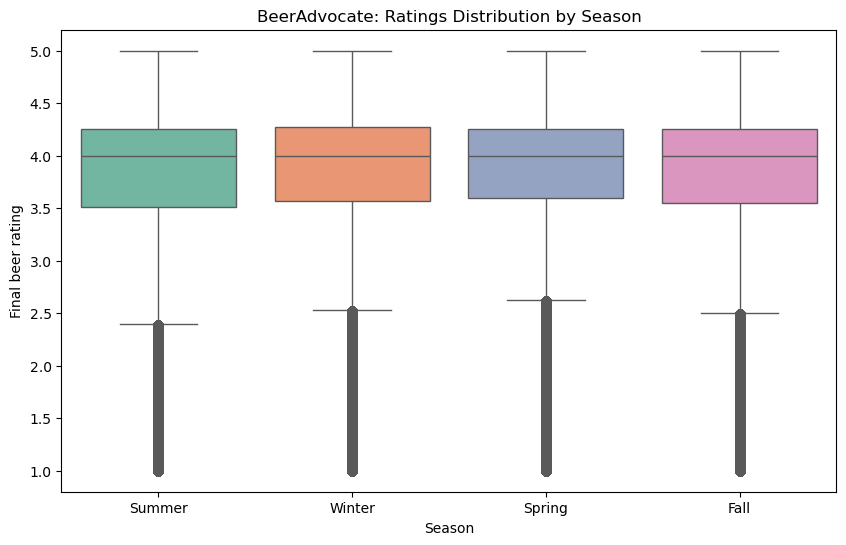

In [166]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='rating', data=ba_ratings_top_10_locations, palette="Set2")
plt.title("BeerAdvocate: Ratings Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Final beer rating")
plt.show()
plt.close()

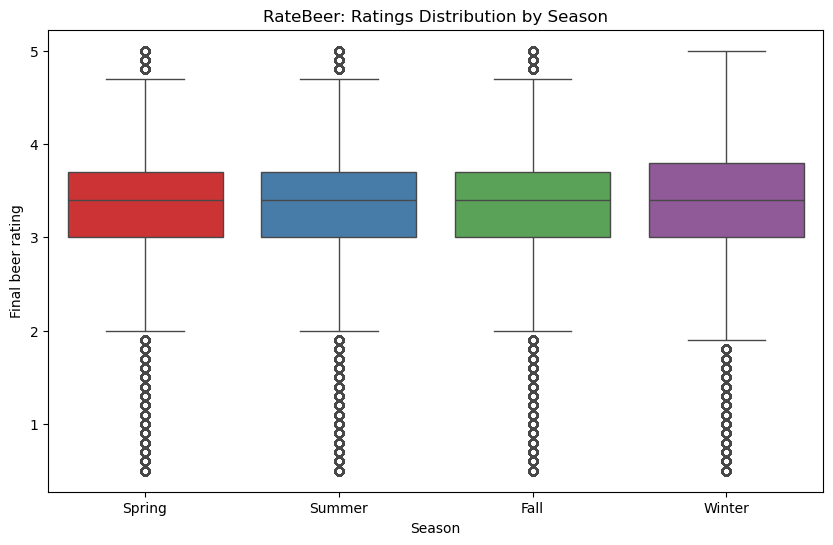

In [167]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='rating', data=rb_ratings_top_10_locations, palette="Set1")
plt.title("RateBeer: Ratings Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Final beer rating")
plt.show()
plt.close()

This part calculates the average rating for each season on both platforms and then combines these into a single DataFrame for easier comparison

In [168]:
# Group by season, then calculate average final rating within each season
ba_seasonal_avg = ba_ratings_top_10_locations.groupby('season')['rating'].mean().reset_index()
rb_seasonal_avg = rb_ratings_top_10_locations.groupby('season')['rating'].mean().reset_index()

In [169]:
# Combine BeerAdvocate and RateBeer seasonal averages
seasonal_avg = pd.concat([ba_seasonal_avg, rb_seasonal_avg], keys=['BeerAdvocate', 'RateBeer']).reset_index(level=0).rename(columns={'level_0': 'source'})
seasonal_avg = seasonal_avg.groupby(['season', 'source'])['rating'].mean().unstack()

In [170]:
print("Seasonal Bias Analysis - Average Ratings per Style by Season")
display(seasonal_avg)

Seasonal Bias Analysis - Average Ratings per Style by Season


source,BeerAdvocate,RateBeer
season,,
Fall,3.887344,3.281864
Spring,3.902042,3.306566
Summer,3.862566,3.268409
Winter,3.898220,3.305275


Both BeerAdvocate and RateBeer show slight variations in ratings across seasons. Average ratings on BeerAdvocate are relatively stable, with minor variations, while RateBeer ratings show a bit more fluctuation across seasons. Winter and Spring generally have slightly higher ratings than Summer and Fall, possibly due to seasonal preferences for richer or stronger beers that are typically enjoyed in cooler weather.

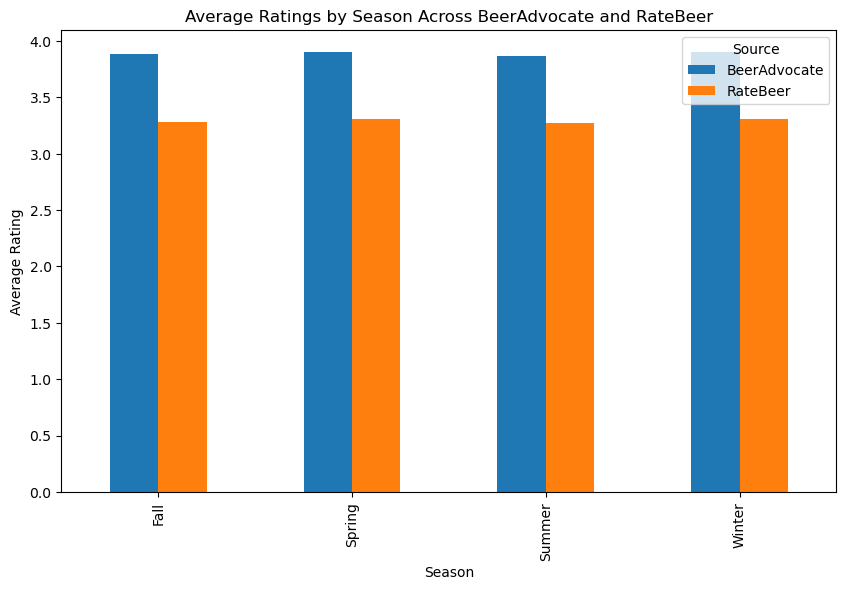

In [171]:
# Plot average ratings across seasons
seasonal_avg.plot(kind='bar', figsize=(10, 6))
plt.title("Average Ratings by Season Across BeerAdvocate and RateBeer")
plt.xlabel("Season")
plt.ylabel("Average Rating")
plt.legend(title='Source')
plt.show()
plt.close()

BeerAdvocate ratings tend to be consistently higher than those on RateBeer across all seasons, which might reflect differences in user base preferences or rating scales.

In [172]:
# Correlation matrix for seasonal ratings between BeerAdvocate and RateBeer
correlation_matrix = seasonal_avg.corr()
print("Correlation Matrix of Seasonal Ratings between BeerAdvocate and RateBeer")
display(correlation_matrix)

Correlation Matrix of Seasonal Ratings between BeerAdvocate and RateBeer


source,BeerAdvocate,RateBeer
source,,
BeerAdvocate,1.000000,0.951294
RateBeer,0.951294,1.000000


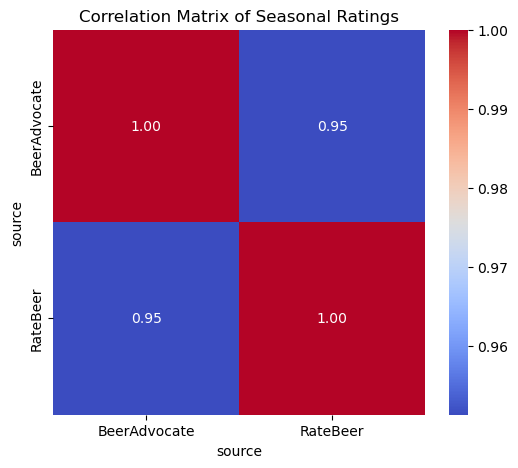

In [173]:
# Heatmap of correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Seasonal Ratings")
plt.show()
plt.close()

The high correlation (0.95) between BeerAdvocate and RateBeer seasonal ratings indicates that both platforms exhibit similar seasonal patterns, despite variations in their absolute values.

## b) Experience biais

To analyze how users’ rating tendencies evolve with experience, we will focus on users who have posted a substantial number of reviews, based on a chosen threshold. Let us set that threshold arbitrarily to 15 reviews, which seems like a number of reviews that is high enough to be able to define different experience levels.

First, let us verify that we have enough users who wrote at least this many reviews.

In [174]:
REVIEW_NB_THRESHOLD = 15

# calculate the counts of each 'user_id' in the review dataframes
ba_user_counts = ba_ratings['user_id'].value_counts()
rb_user_counts = rb_ratings['user_id'].value_counts()

# keep only user_id values that appear at least 15 times
ba_prolific_users = ba_user_counts[ba_user_counts >= REVIEW_NB_THRESHOLD].index.tolist()
rb_prolific_users = rb_user_counts[rb_user_counts >= REVIEW_NB_THRESHOLD].index.tolist()

print("Number of users who wrote at least",REVIEW_NB_THRESHOLD,"reviews:")
print('Beer Advocate:',len(ba_prolific_users))
print('Rate Beer:',len(rb_prolific_users))

Number of users who wrote at least 15 reviews:
Beer Advocate: 39945
Rate Beer: 13832


We have about 40 and 14 thousand users who wrote at least 15 reviews on Beer Advocate and Rate Beer, respectively, which seems to be enough data to do perform our analysis. We can also note that we have significantly more data from Beer Advocate than from Rate Beer.
Let us now isolate reviews from these users.

In [175]:
# filter rating dataframes to isolate users who wrote at least 15 reviews
prolific_ba_users_ratings = ba_ratings[ba_ratings.user_id.isin(ba_prolific_users)]
prolific_rb_users_ratings = rb_ratings[rb_ratings.user_id.isin(rb_prolific_users)]

Our analysis will start by sorting the reviews of each user chronologically and assigning an "experience level" to each rating based on the number of reviews they had posted up to that point. These levels will be predefined and consistent across all users: new reviewer (first n reviews), amateur (from the n+1th to the oth review), and expert (from the o+1th review onward).

Let us define these experience levels arbitrarily: we will consider that a user is a new reviewer for the first 5 reviews, an amateur for the 6th to the 10th review and and expert starting from the 11th review. 

In [176]:
# define experience levels
NEW_REVIEWER_THRESHOLD = 5
AMATEUR_THRESHOLD = 10

Let us now add experience levels to the reviews of users who wrote at least 15 reviews

In [177]:
ba_ratings_with_experience_levels = assign_experience_level(prolific_ba_users_ratings, NEW_REVIEWER_THRESHOLD, AMATEUR_THRESHOLD)
ba_ratings_with_experience_levels.sample(5)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,experience_level
2422437,Drew Curtis / Wil Wheaton / Greg Koch Stone Fa...,96528.0,Stone Brewing,147.0,American Double / Imperial Stout,13.0,2013-08-29 09:59:28,jpd026,jpd026.659782,NaN,NaN,NaN,NaN,NaN,5.00,expert
2282087,Sculpin IPA,29619.0,Ballast Point Brewing Company,199.0,American IPA,7.0,2014-08-18 09:59:28,dannykperkins,dannykperkins.834892,NaN,NaN,NaN,NaN,NaN,4.44,expert
4997102,The Great Dismal Black IPA,63699.0,O'Connor Brewing Co.,22783.0,American Black Ale,7.5,2014-06-01 10:00:00,wollefdoogylloj,wollefdoogylloj.487456,4.5,4.0,4.5,4.5,4.5,4.38,expert
5649980,Park Day Bohemian Pilsner,116724.0,Mother Earth Brewing,21193.0,Czech Pilsener,4.9,2014-04-04 09:59:28,kristougher,kristougher.738899,NaN,NaN,NaN,NaN,NaN,4.00,expert
6817437,Kuhnhenn Bourbon Barrel Fourth Dementia,34313.0,Kuhnhenn Brewing Company,2097.0,Old Ale,13.5,2011-11-14 10:59:12,mgbickel,mgbickel.396403,NaN,NaN,NaN,NaN,NaN,5.00,expert


In [178]:
rb_ratings_with_experience_levels = assign_experience_level(prolific_rb_users_ratings, NEW_REVIEWER_THRESHOLD, AMATEUR_THRESHOLD)
rb_ratings_with_experience_levels.sample(5)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,experience_level
3308372,Russian River Supplication,43947.0,Russian River Brewing,1480.0,Sour Red/Brown,7.75,2005-08-08 09:59:28,hopscotch,4850.0,4.0,8.0,4.0,8.0,15.0,3.9,expert
4734998,Otter Creek White Sail,71855.0,Otter Creek Brewing,417.0,Witbier,5.00,2007-08-27 09:59:28,Palidor19,11056.0,3.0,5.0,3.0,5.0,11.0,2.7,expert
1250931,Berliner Kindl Weisse Mit Schuß Waldmeister,22675.0,Berliner Kindl Schultheiss Brauerei &#40;Oetke...,961.0,Berliner Weisse,3.00,2014-07-10 10:00:00,LordAltbier,325580.0,4.0,8.0,4.0,8.0,10.0,3.4,expert
778872,Stevns Bondens Bryg,105839.0,Stevns Bryghus,6425.0,Oktoberfest/Märzen,5.00,2010-05-10 10:00:00,saxo,28282.0,2.0,5.0,2.0,6.0,11.0,2.6,expert
271702,Canoe Red Canoe Lager,15622.0,Canoe Brewpub,2719.0,Pilsener,5.20,2012-01-18 11:00:00,riversideAK,37954.0,3.0,7.0,3.0,7.0,13.0,3.3,expert


We will now calculate the average final rating (denoted as 'rating' in the ratings DataFrames) for each experience level across all users.

In [179]:
experience_order = ['new_reviewer', 'amateur', 'expert']

# average final rating for each experience level for BeerAdvocate data
ba_final_rating_by_experience_level = ba_ratings_with_experience_levels.groupby('experience_level')['rating'].mean().reindex(experience_order)
print('BeerAdvocate:\n',ba_final_rating_by_experience_level)

# average final rating for each experience level for RateBeer data
rb_final_rating_by_experience_level = rb_ratings_with_experience_levels.groupby('experience_level')['rating'].mean().reindex(experience_order)
print('RateBeer:\n',rb_final_rating_by_experience_level)

BeerAdvocate:
 experience_level
new_reviewer    3.972625
amateur         3.934939
expert          3.870160
Name: rating, dtype: float64
RateBeer:
 experience_level
new_reviewer    3.306333
amateur         3.296469
expert          3.279586
Name: rating, dtype: float64


Let us visualize the results with a bar chart.

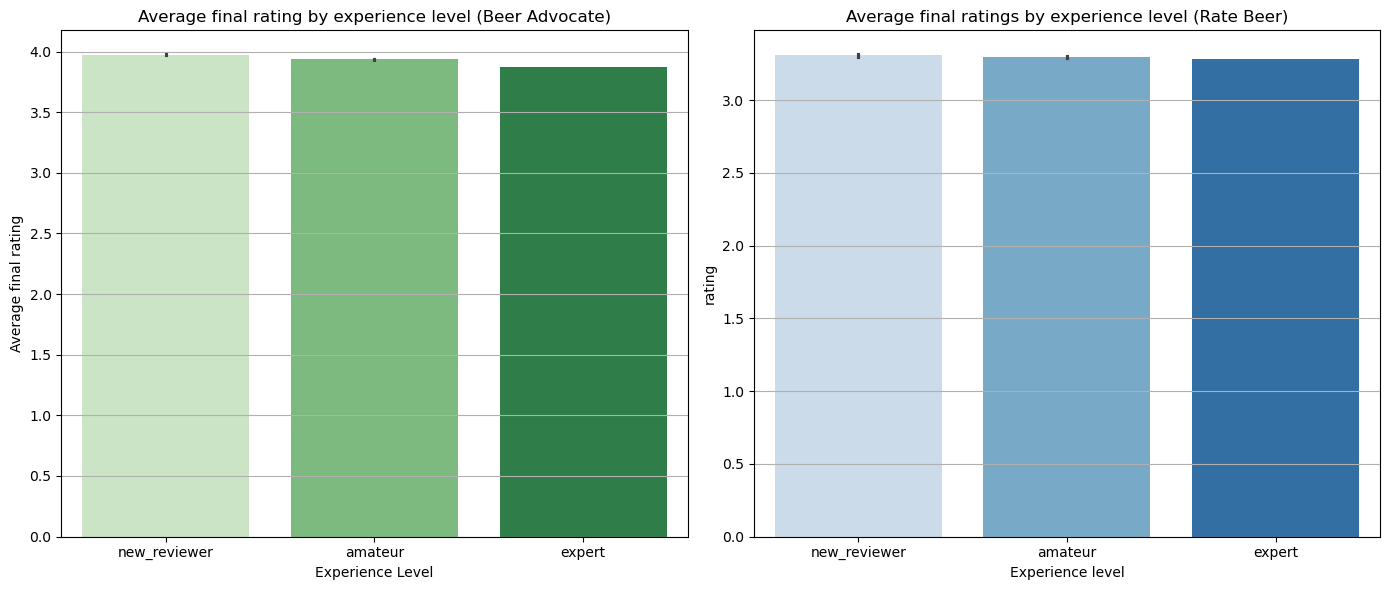

In [180]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='experience_level', y='rating', data=ba_ratings_with_experience_levels, order=['new_reviewer', 'amateur', 'expert'], ci=95, palette='Greens')
plt.title('Average final rating by experience level (Beer Advocate)')
plt.xlabel('Experience Level')
plt.ylabel('Average final rating')
plt.grid(True, axis='y')

plt.subplot(1, 2, 2)
sns.barplot(x='experience_level', y='rating', data=rb_ratings_with_experience_levels, order=['new_reviewer', 'amateur', 'expert'], ci=95, palette='Blues')
plt.title('Average final ratings by experience level (Rate Beer)')
plt.xlabel('Experience level')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()
plt.close()

For both Beer Advocate and Beer Review data, we can see that the average final rating given by "expert" users is slightly smaller than that given by "new reviewers". While the difference is small, the confidence itervals do not overlap, suggesting that the differences, despite being small, may be significant.

Let us investigate this phenomenon further by examining how final ratings evolve with experience when considering users separately. To do so, we will test whether the average rating of reviews labeled as 'new_reviewer' is greater than the average rating of reviews labeled as 'expert' for a given user, using a one-tailed t-test.

In [181]:
# Beer Advocate
# group the data by 'user_id' and 'experience_level' to calculate the average rating for each experience level and for each user
ba_average_final_rating_by_user_and_experience_level = ba_ratings_with_experience_levels.groupby(['user_id', 'experience_level'])['rating'].mean().unstack()

# perform a one-tailed t-test
t_stat, p_value = ttest_rel(ba_average_final_rating_by_user_and_experience_level['new_reviewer'], ba_average_final_rating_by_user_and_experience_level['expert'])

if t_stat > 0:  # case where 'new reviewer' average rating is greater than 'expert' average rating
    one_tailed_p_value = p_value / 2
    print(f"T-statistic: {t_stat}, One-tailed P-value: {one_tailed_p_value}")

else: # case where 'new reviewer' average rating is smaller than 'expert' average rating
    print('No support found for the alternative hypothesis that new_reviewer ratings are greater than expert ratings.')

T-statistic: 19.177932951518155, One-tailed P-value: 6.593412822779312e-82


In [182]:
# Rate Beer
# group the data by 'user_id' and 'experience_level' to calculate the average rating for each experience level and for each user
rb_average_final_rating_by_user_and_experience_level = rb_ratings_with_experience_levels.groupby(['user_id', 'experience_level'])['rating'].mean().unstack()

# perform a one-tailed t-test
t_stat, p_value = ttest_rel(rb_average_final_rating_by_user_and_experience_level['new_reviewer'], rb_average_final_rating_by_user_and_experience_level['expert'])

if t_stat > 0:  # case where 'new reviewer' average rating is greater than 'expert' average rating
    one_tailed_p_value = p_value / 2
    print(f"T-statistic: {t_stat}, One-tailed P-value: {one_tailed_p_value}")
    
else: # case where 'new reviewer' average rating is smaller than 'expert' average rating
    print('No support found for the alternative hypothesis that new_reviewer ratings are greater than expert ratings.')

No support found for the alternative hypothesis that new_reviewer ratings are greater than expert ratings.


Given the output for the Rate Beer data, let us instead test whether the average rating of reviews labeled as 'new_reviewer' is lower than the average rating of reviews labeled as 'expert' for a given user.

In [183]:
# perform a one-tailed t-test
t_stat, p_value = ttest_rel(rb_average_final_rating_by_user_and_experience_level['expert'], rb_average_final_rating_by_user_and_experience_level['new_reviewer'])

if t_stat > 0:  # case where 'new reviewer' average rating is lower than 'expert' average rating
    one_tailed_p_value = p_value / 2
    print(f"T-statistic: {t_stat}, One-tailed P-value: {one_tailed_p_value}")
    
else: # case where 'new reviewer' average rating is larger than 'expert' average rating
    print('No support found for the alternative hypothesis that expert ratings are greater than new_reviewer ratings.')

T-statistic: 9.561612720178132, One-tailed P-value: 6.759850605180135e-22


The one-tailed t-test testing whether the average rating of reviews labeled as 'new_reviewer' is greater than the average rating of reviews labeled as 'expert' for a given user performed on the Beer Advocate data yielded a positive test statistic, which suggests that the mean of new reviewer ratings is higher than the mean of expert ratings. The p-value is extremely small (p_value << 0.05), which means that the mean of the new_reviewer ratings is significantly higher than the mean of the expert ratings.

In contrast, the one-tailed t-test testing whether the average rating of reviews labeled as 'new_reviewer' is lower than the average rating of reviews labeled as 'expert' for a given user performed on the Rate Beer data yielded a positive test statistic, which suggests that the mean of new reviewer ratings is lower than the mean of expert ratings. The p-value is extremely small (p_value << 0.05), which means that the mean of the new_reviewer ratings is significantly lower than the mean of the expert ratings.

While these results appear contradictory, it is important to note that they were calculated on data from 40,000 users in Beer Advocate versus 14,000 users in Rate Beer. The larger sample size in Beer Advocate may make the corresponding results more representative of user behavior. However, these differences could also reflect distinct user rating cultures (especially since the ditribution of origins of reviewers from the 2 platforms differ significantly) or rating scales between the platforms. Thus, while we cannot conclude with certainty that users become more critical with experience across all platforms, the Beer Advocate data might suggest a trend in this direction. Further analysis with more data from both platforms or additional datasets could clarify if these patterns are platform-specific or represent a broader trend.